In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../cleaning_process/processed_data.csv')
print(df.head())

       Country  Adult Literacy Rate  ICT Service Exports  R&D Expenditure  \
0  Afghanistan             7.828516             0.833702           169.19   
1      Albania             3.013976             0.154120           238.59   
2      Algeria             2.213114             0.478650          7606.65   
3      Andorra             4.348926             0.833702             9.60   
4       Angola            45.414760             0.032290            44.99   

   Journal Articles  Patent Applications  Mobile Subscriptions  \
0      14172.405405            56.554435              0.080087   
1         23.000000            97.885707             22.472000   
2        268.000000           109.165357             12.008700   
3          3.000000           142.214121             51.740100   
4          2.000000            67.373474              0.373669   

   Fixed Broadband Subscriptions  Secure Internet Servers (per million)  \
0                      43.758544                                 

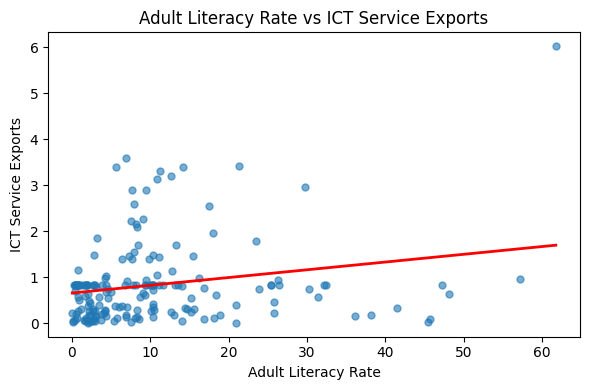

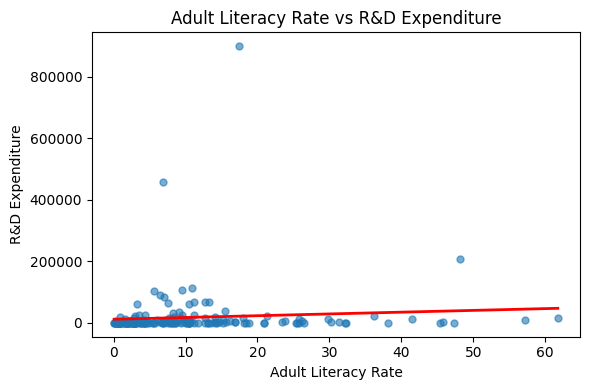

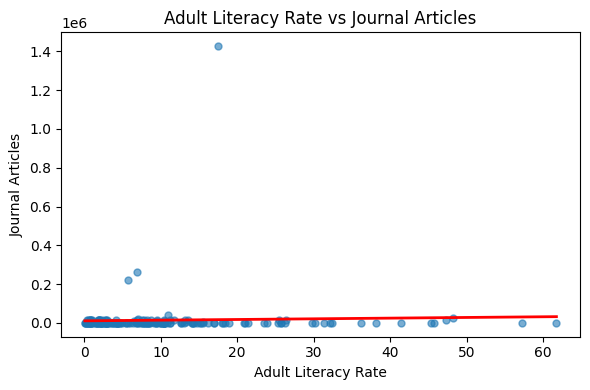

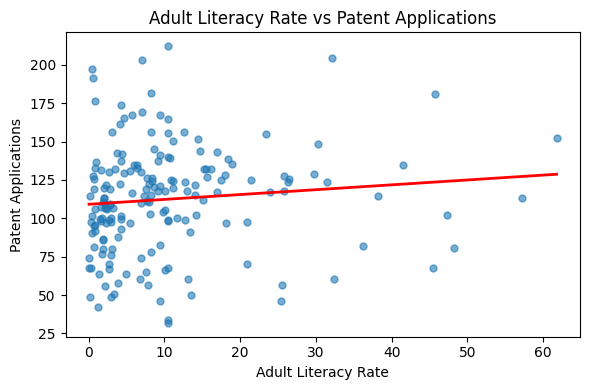

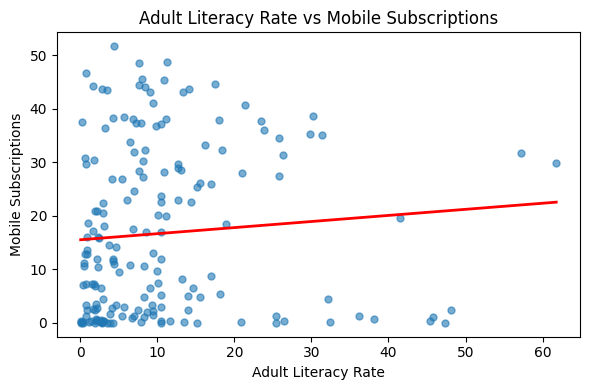

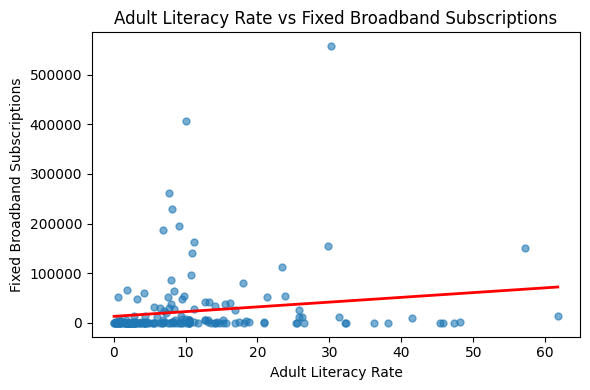

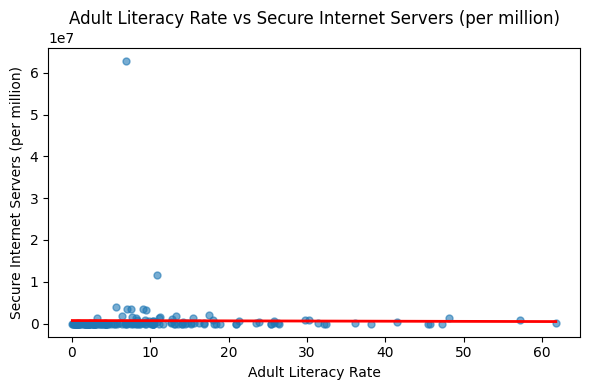

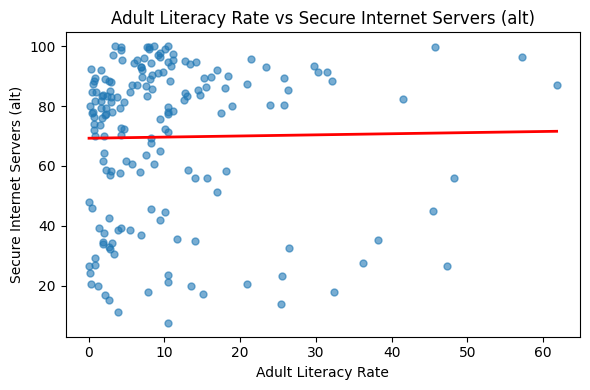

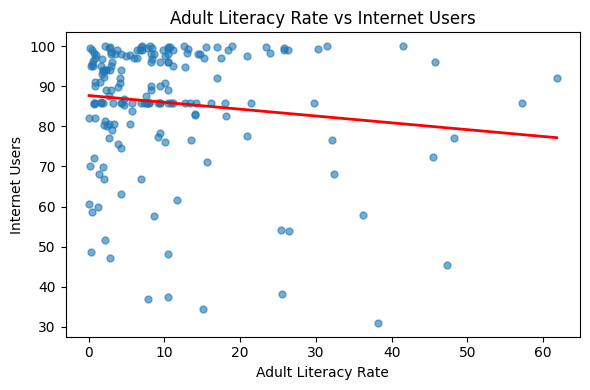

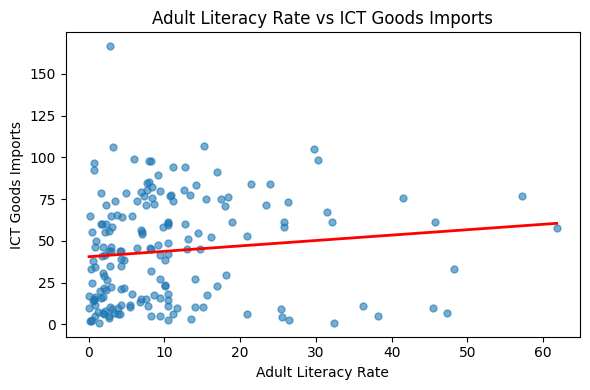

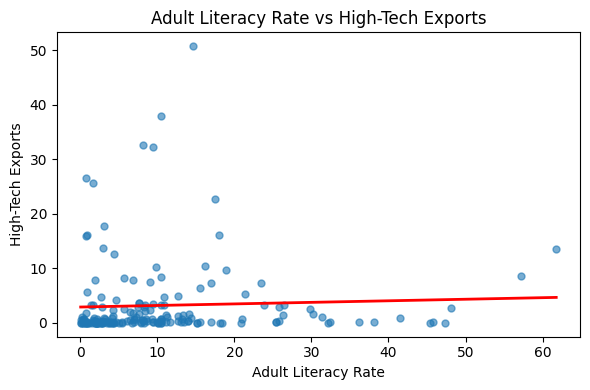

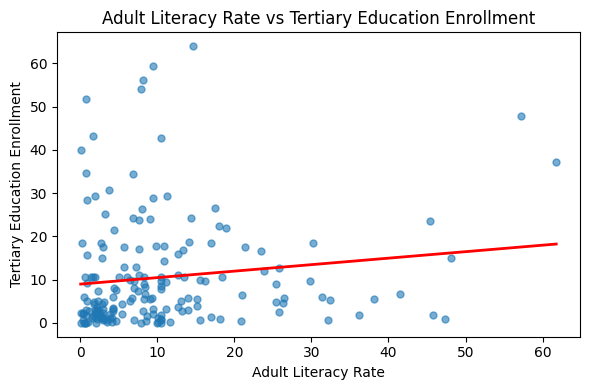

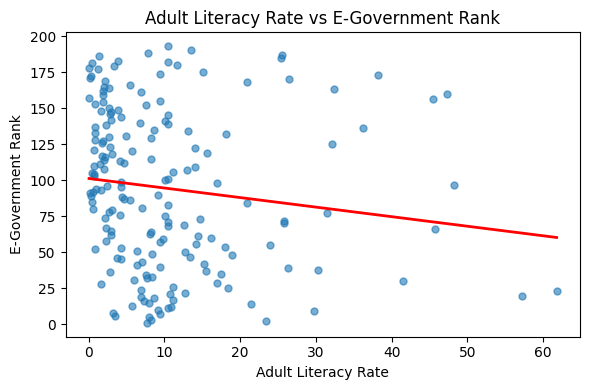

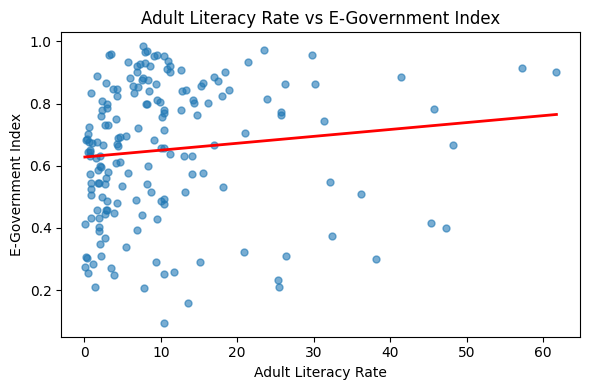

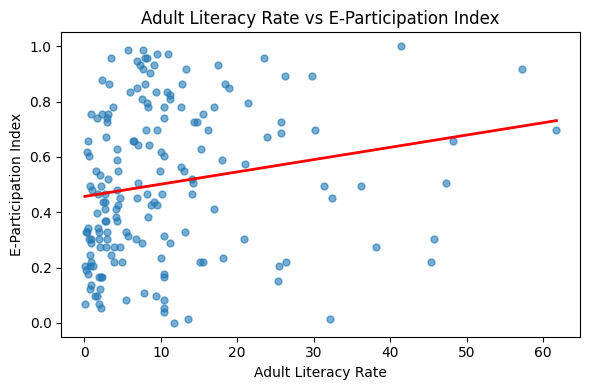

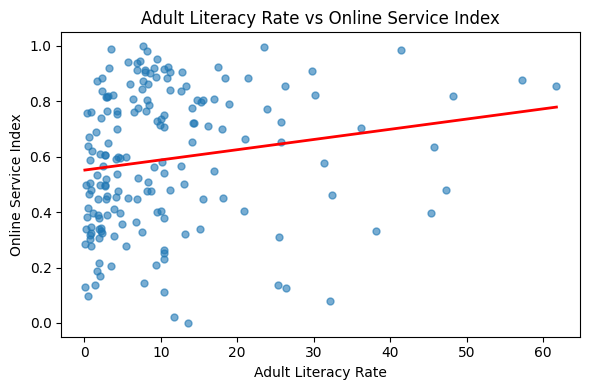

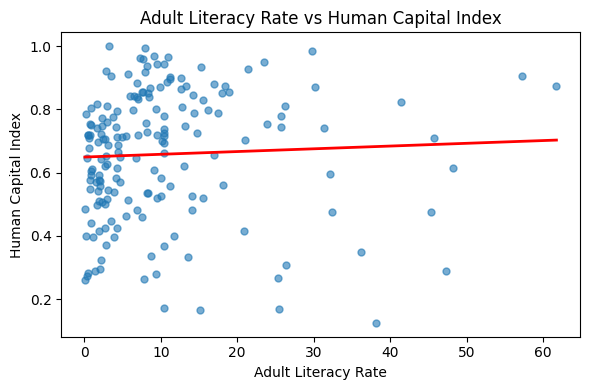

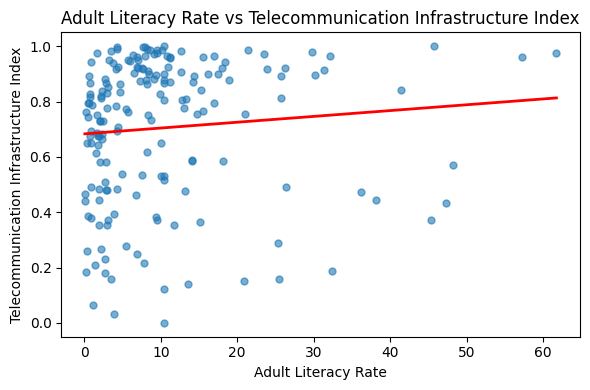

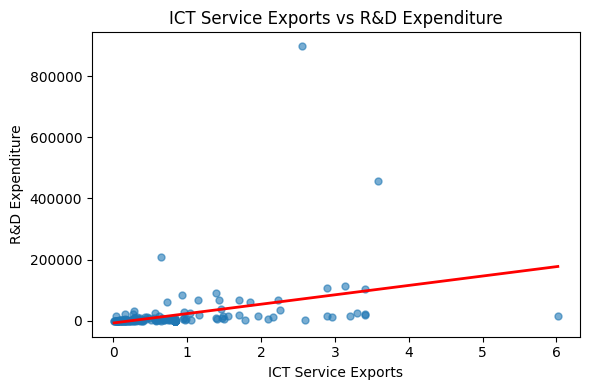

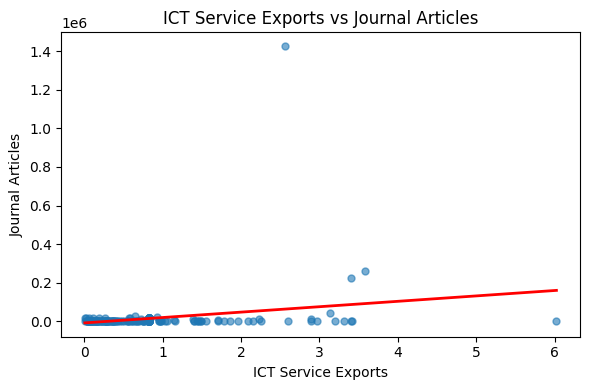

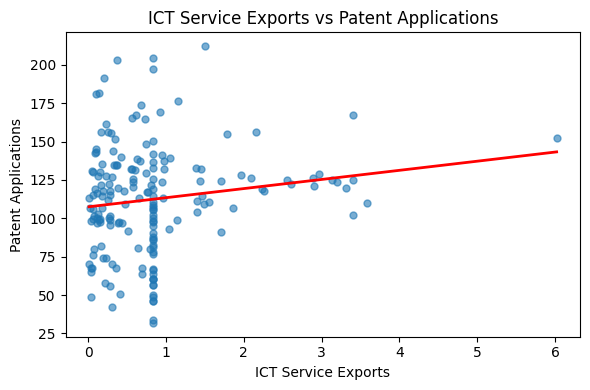

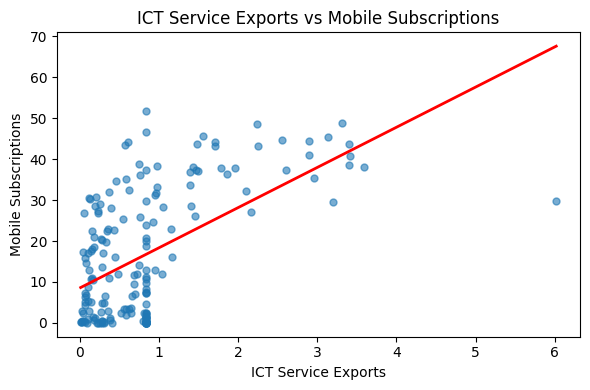

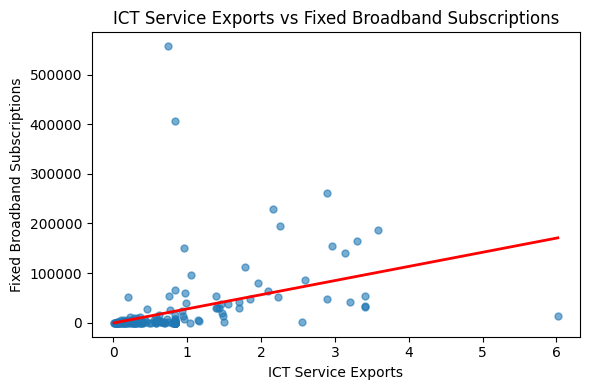

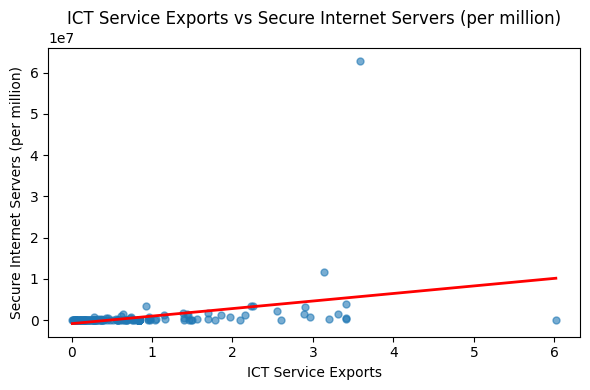

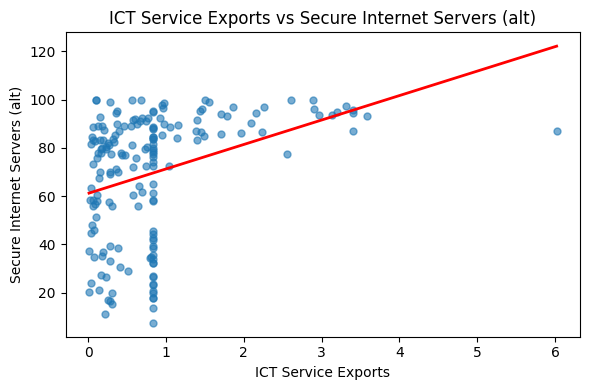

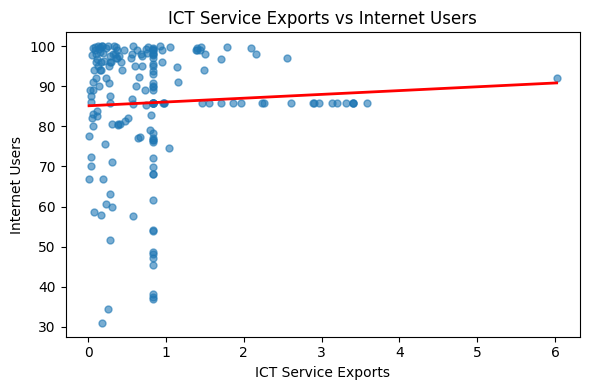

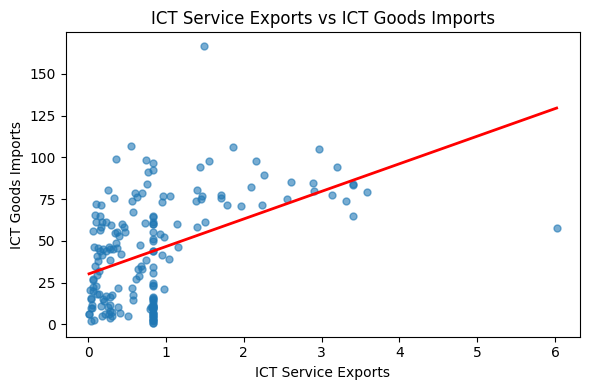

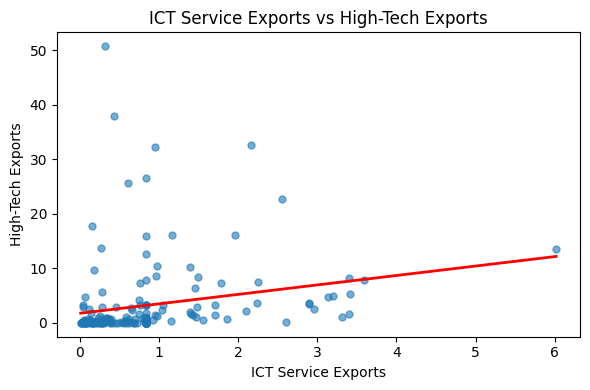

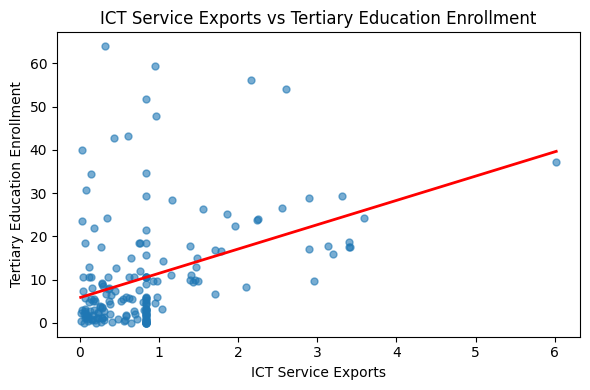

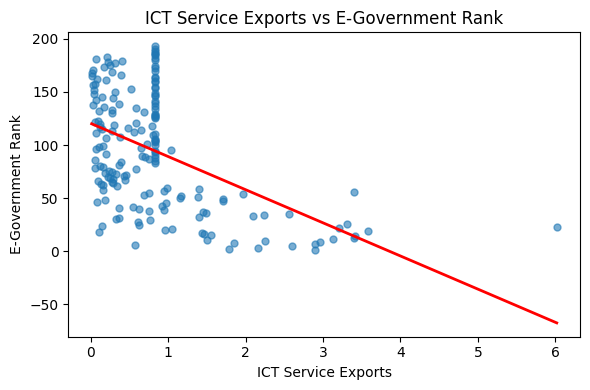

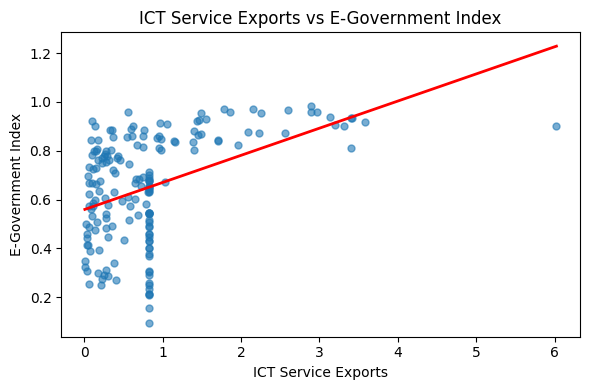

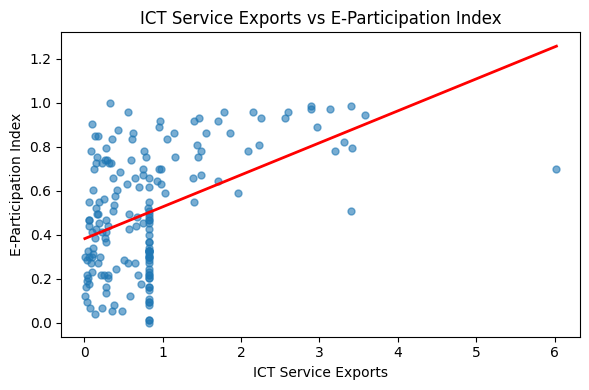

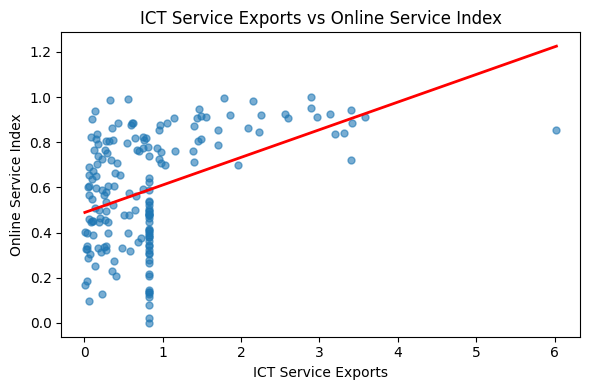

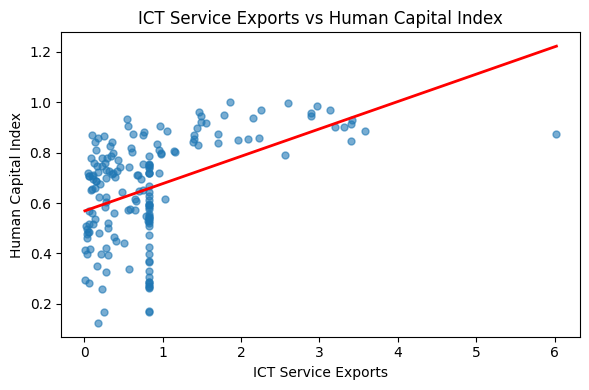

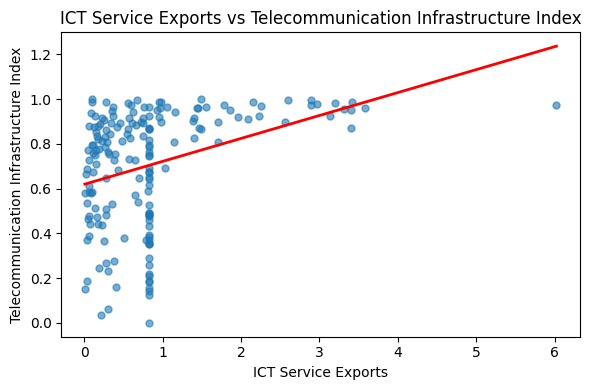

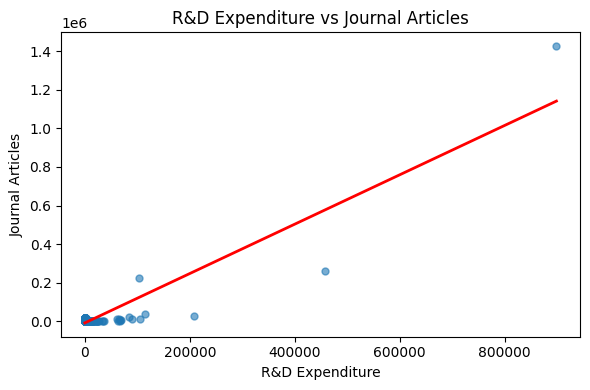

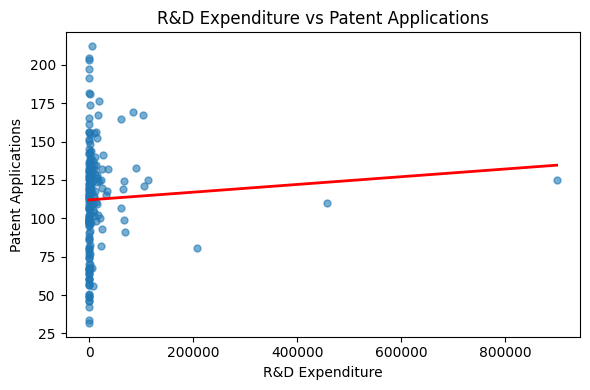

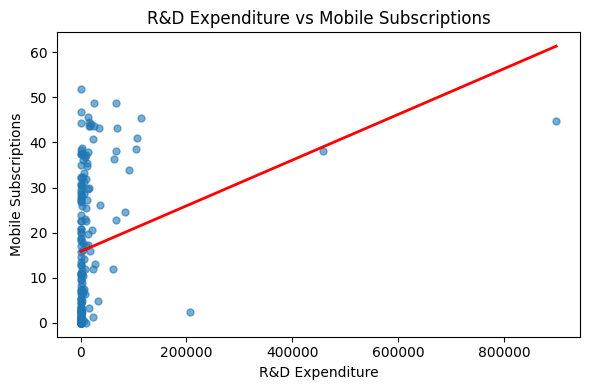

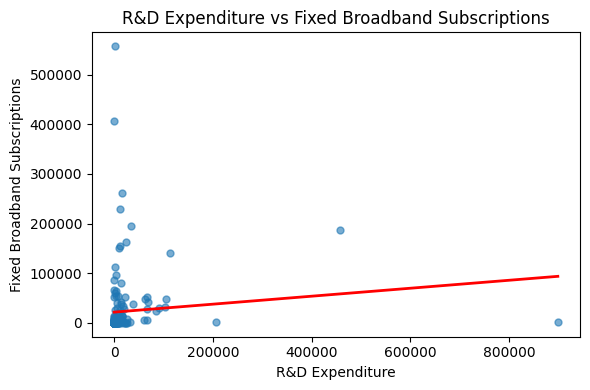

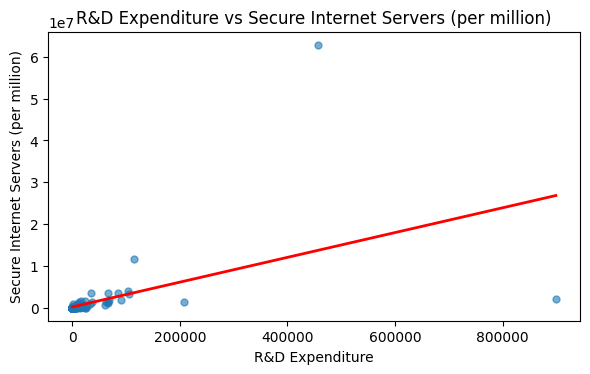

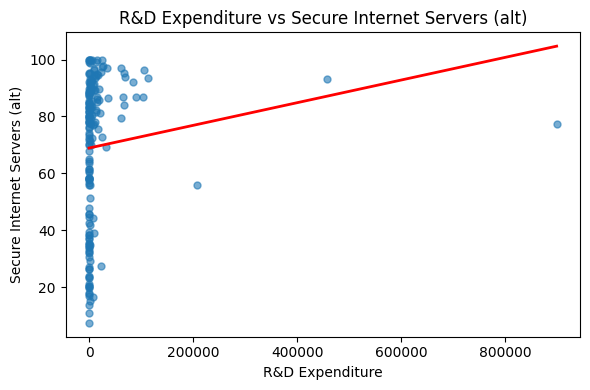

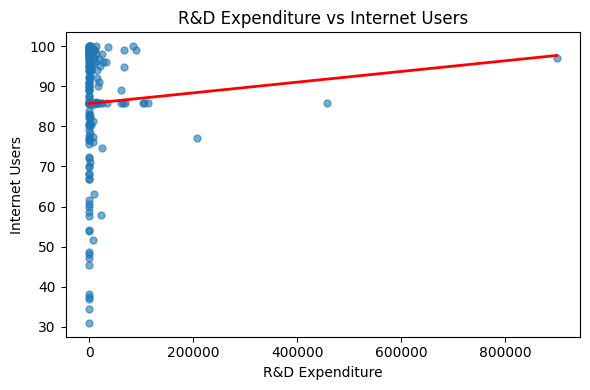

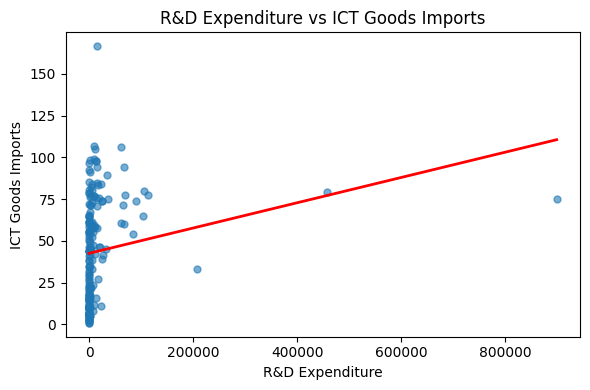

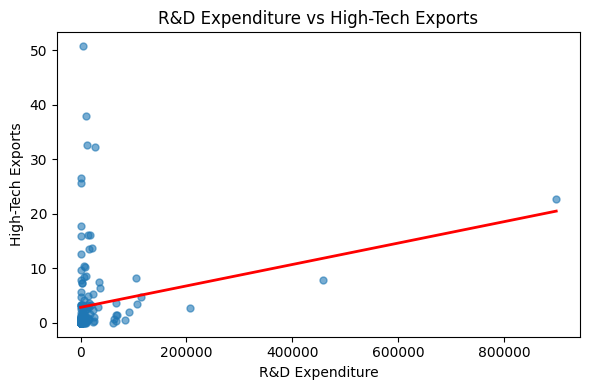

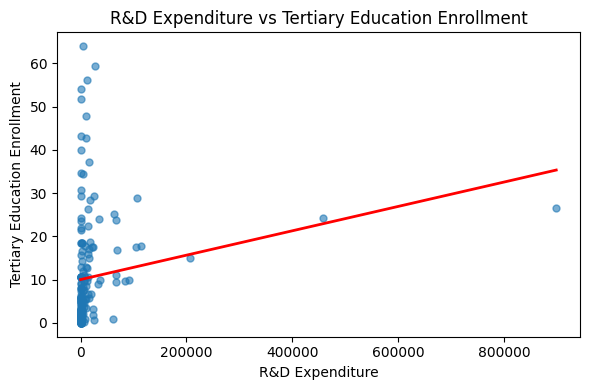

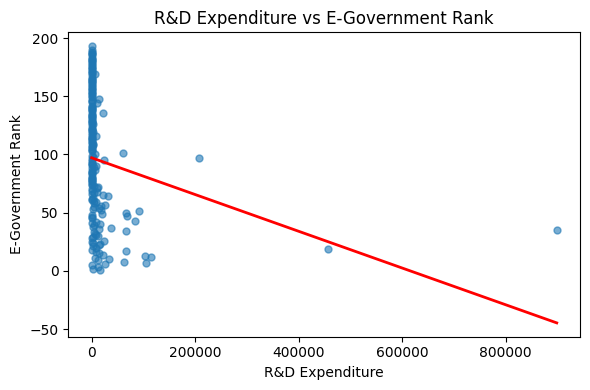

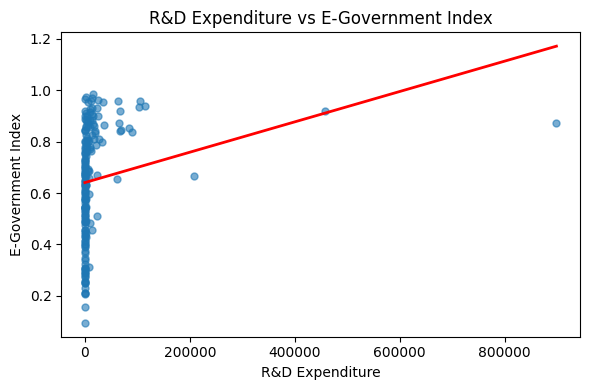

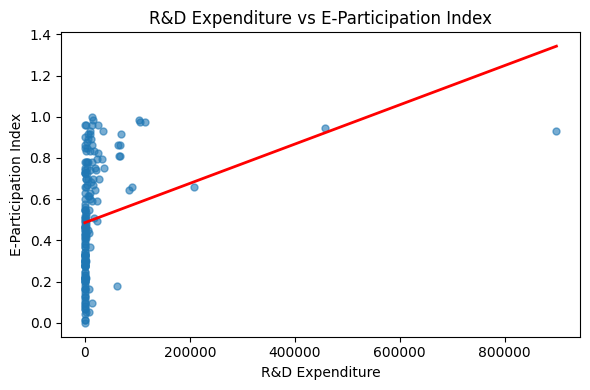

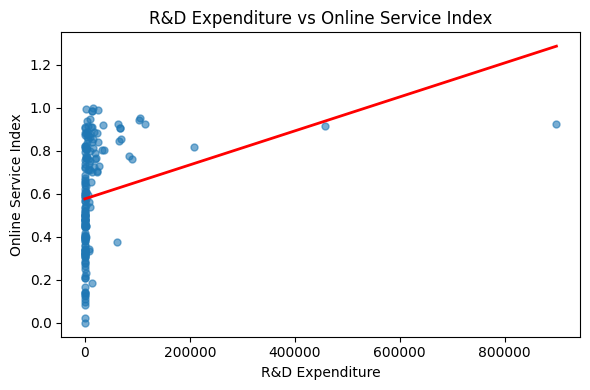

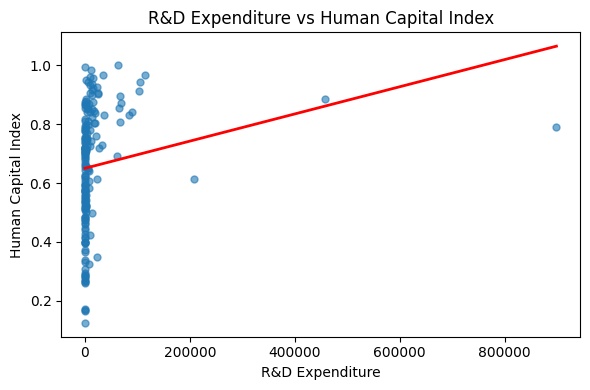

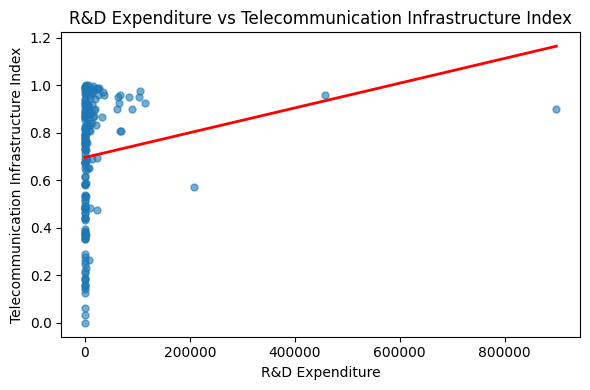

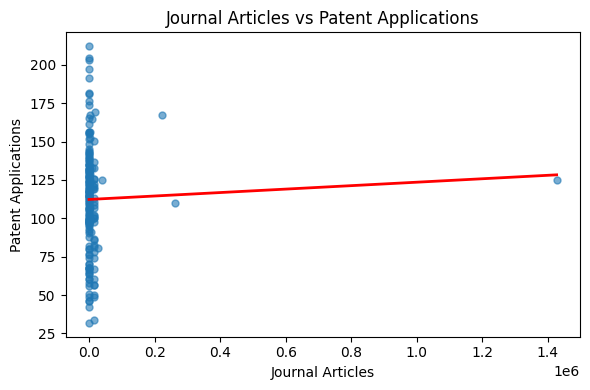

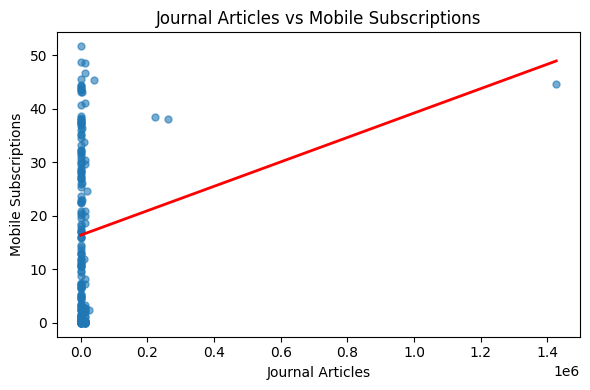

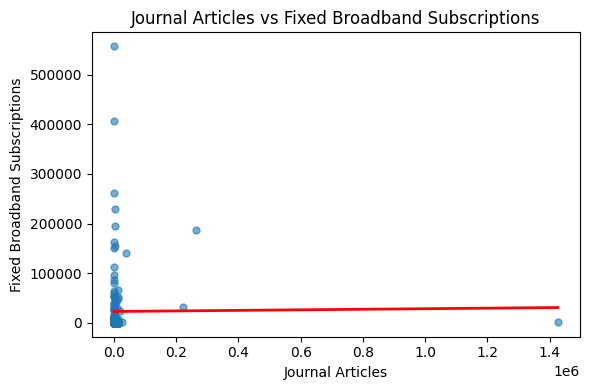

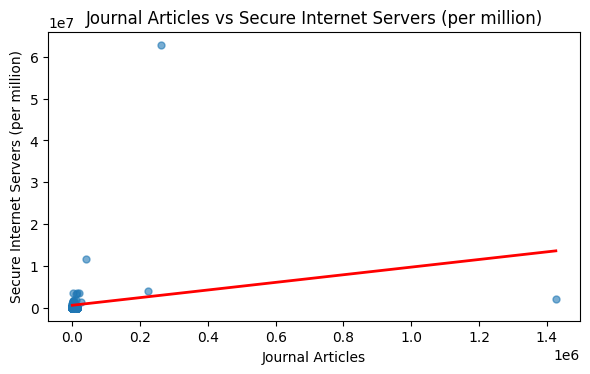

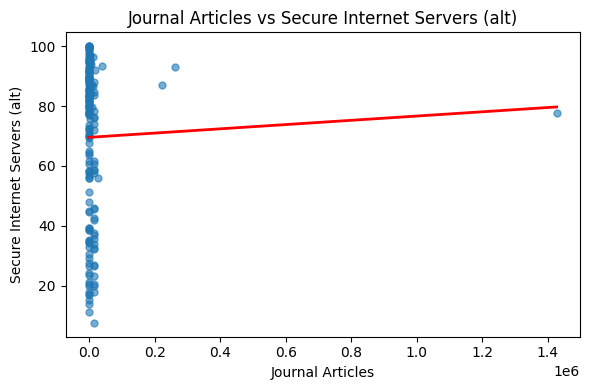

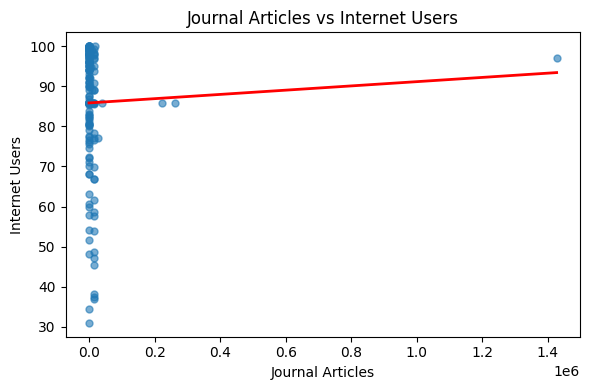

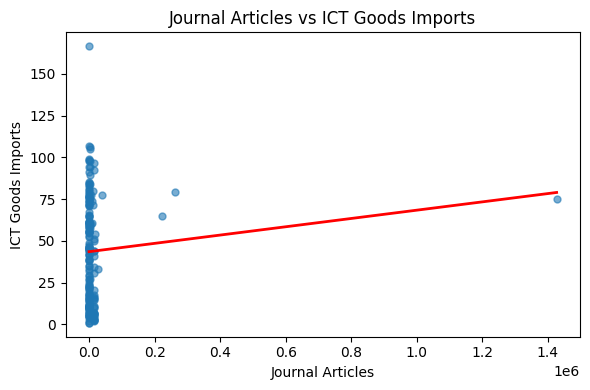

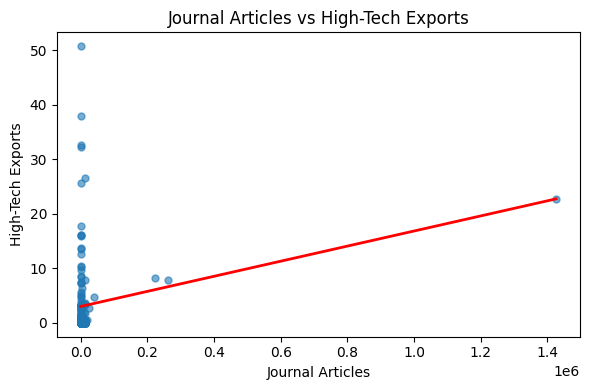

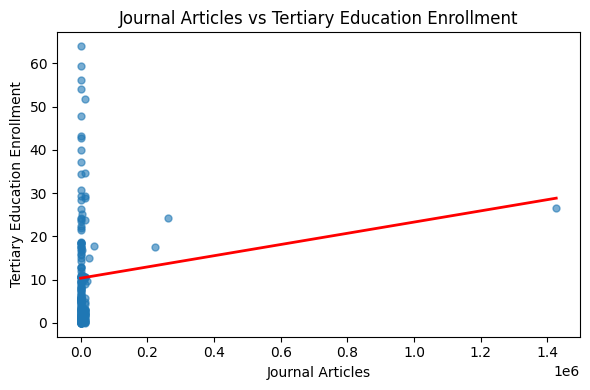

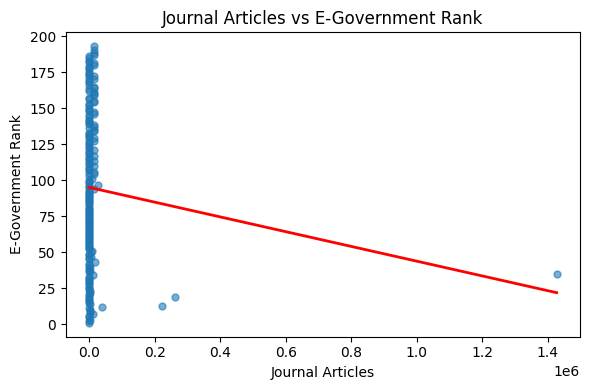

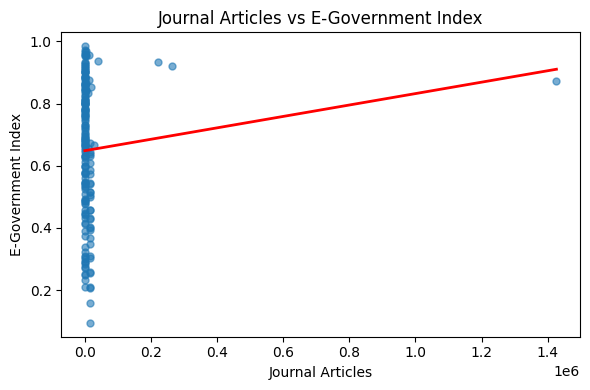

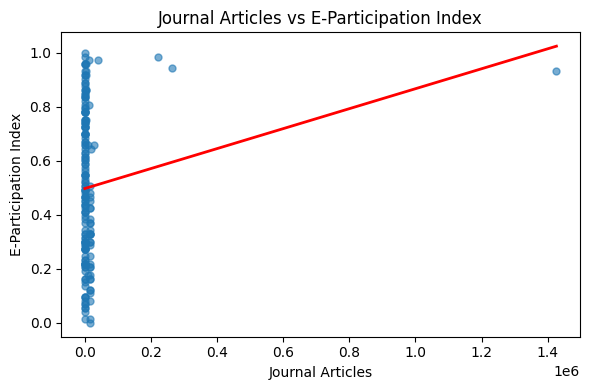

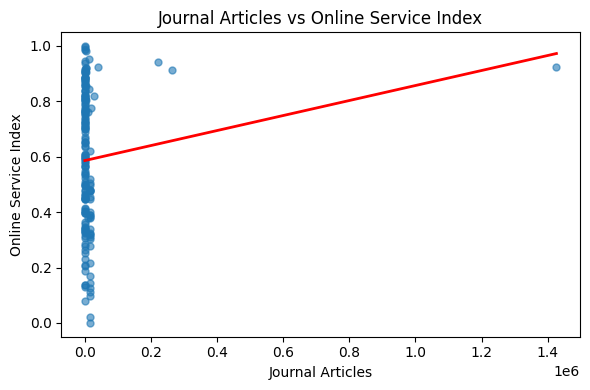

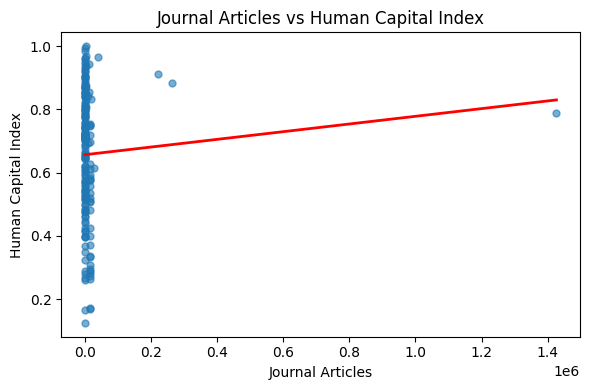

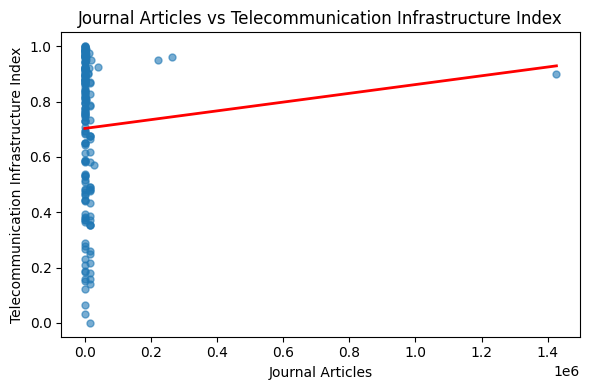

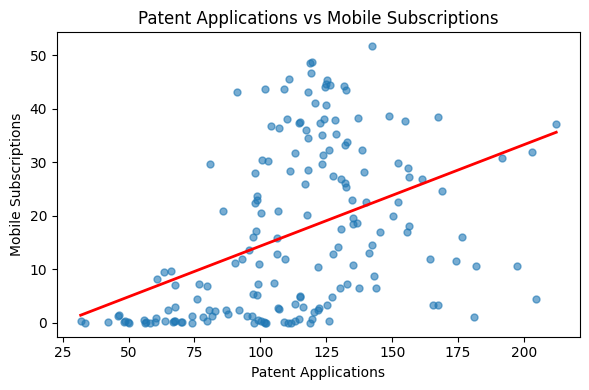

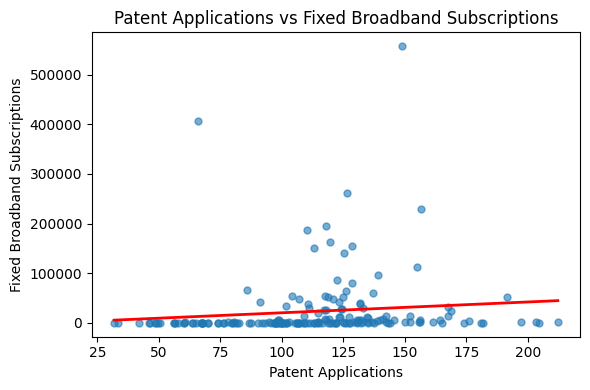

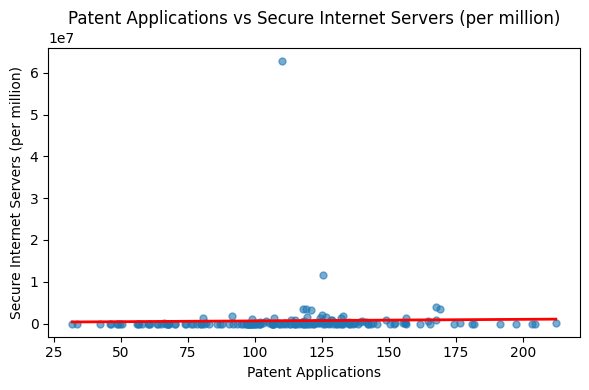

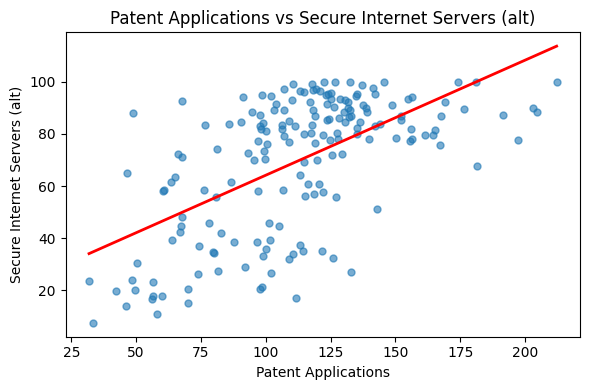

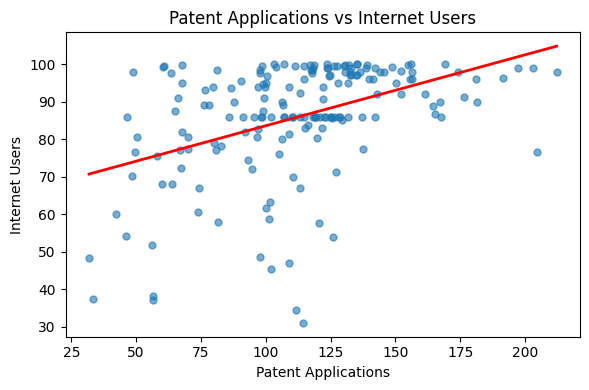

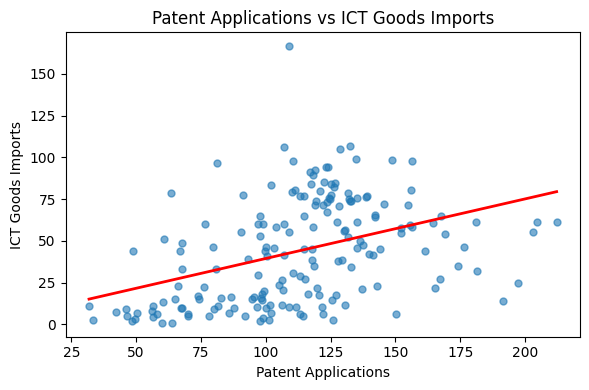

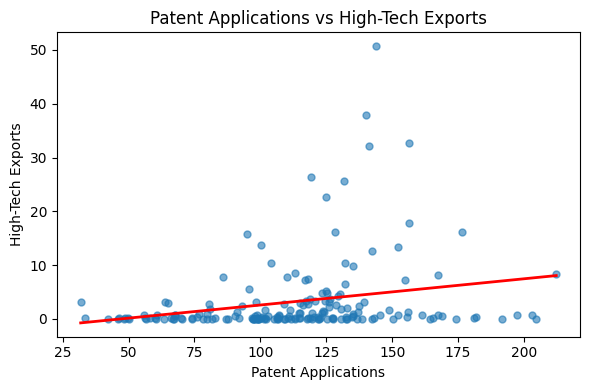

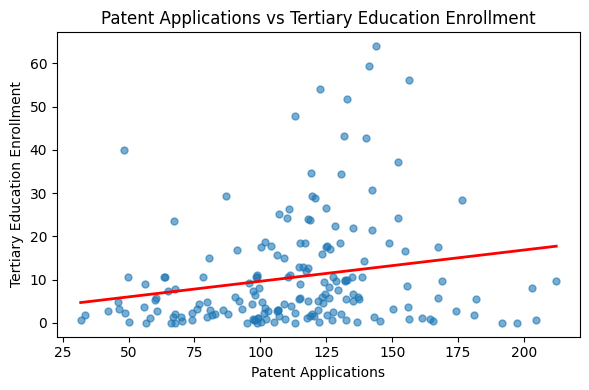

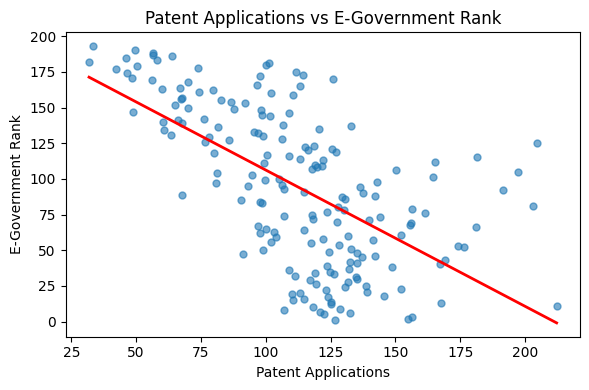

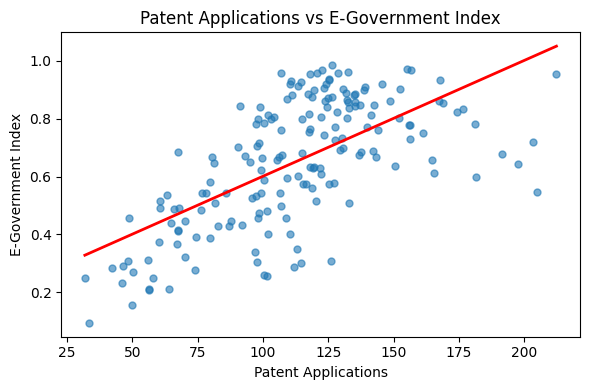

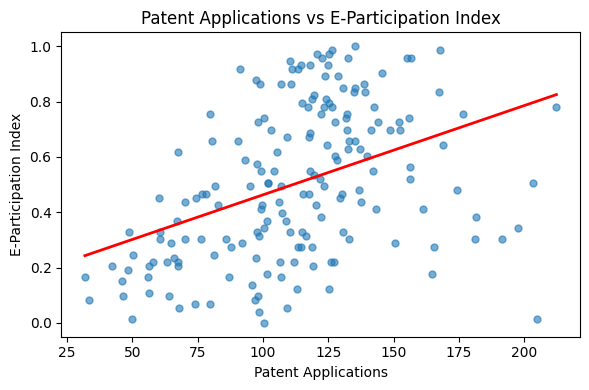

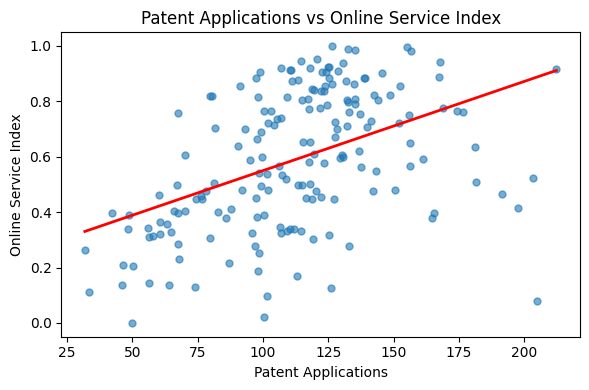

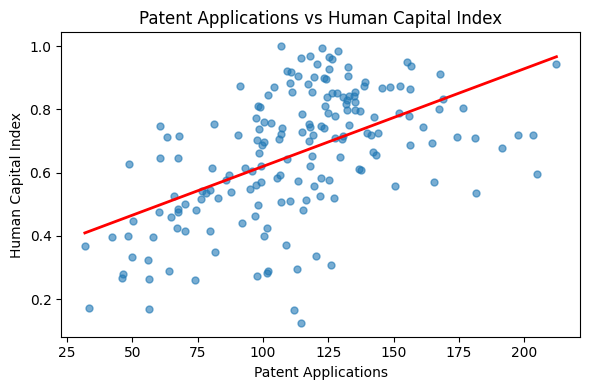

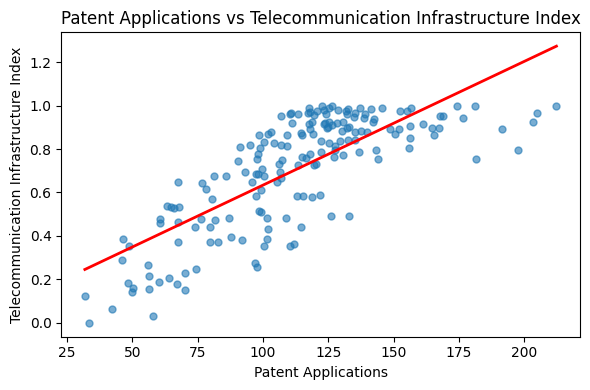

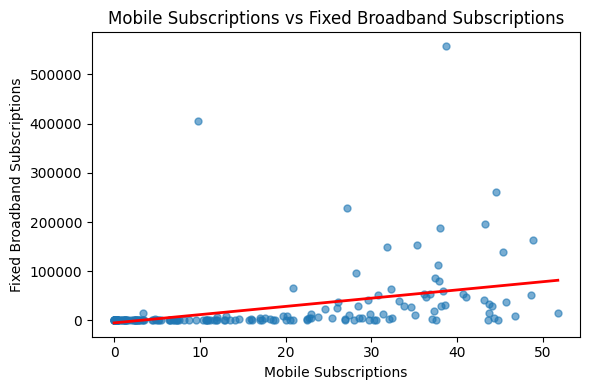

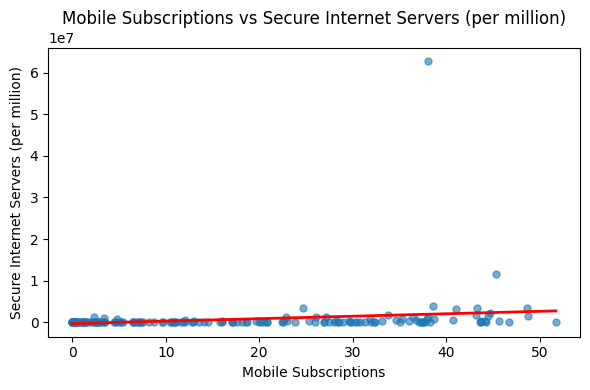

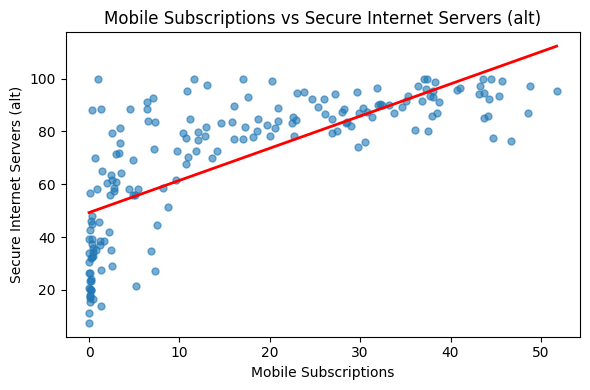

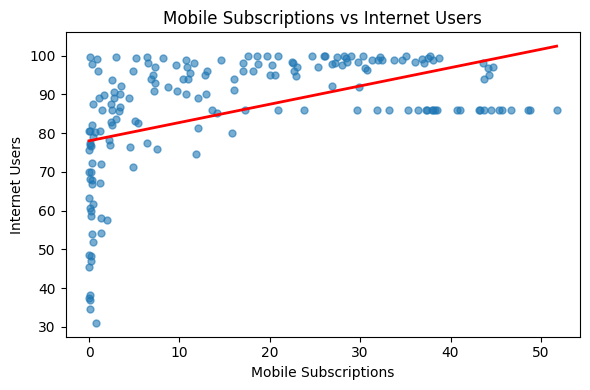

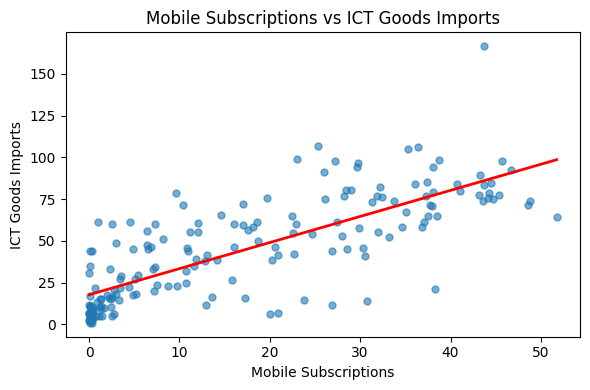

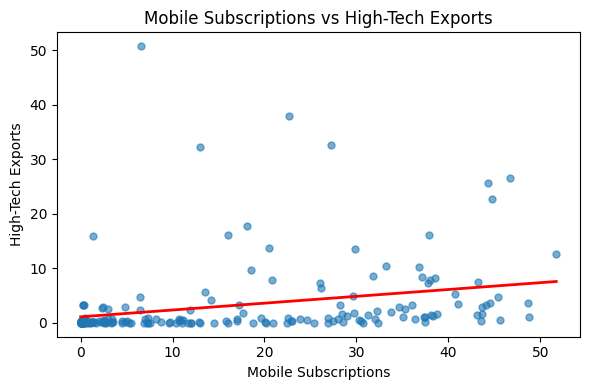

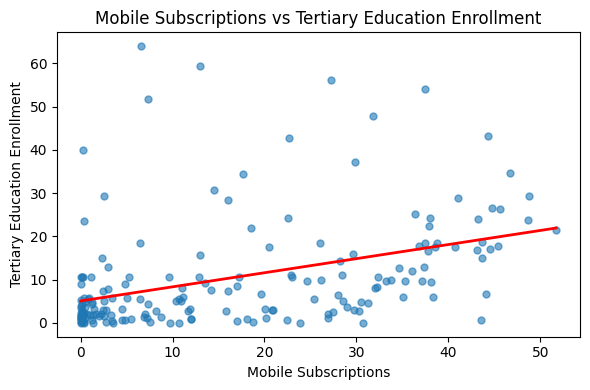

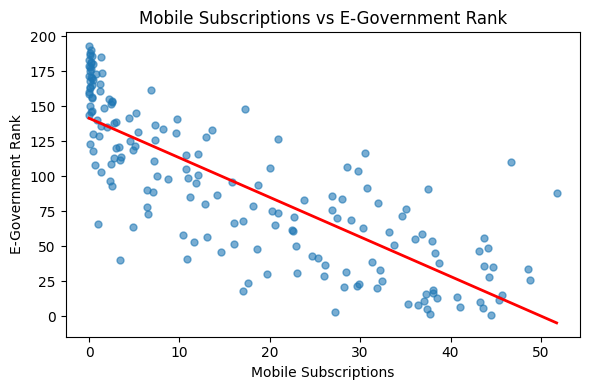

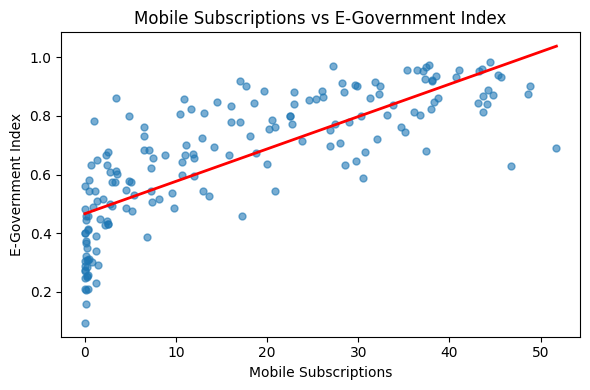

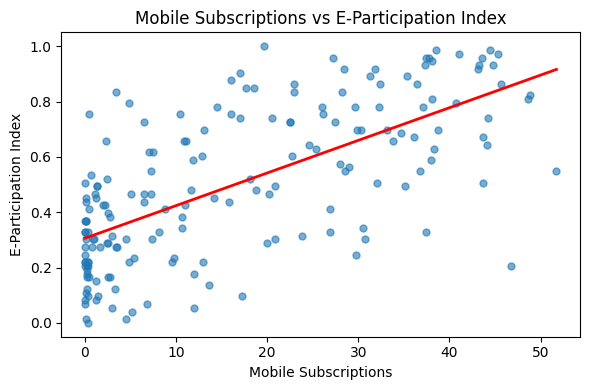

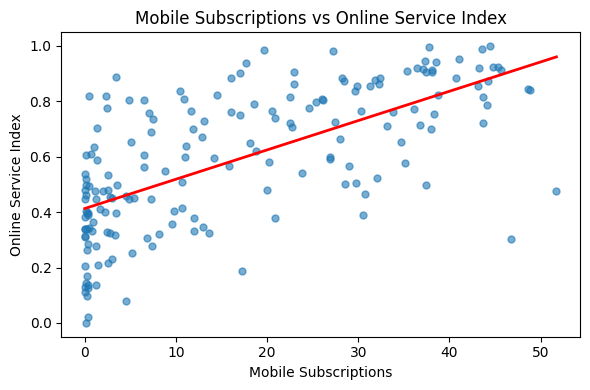

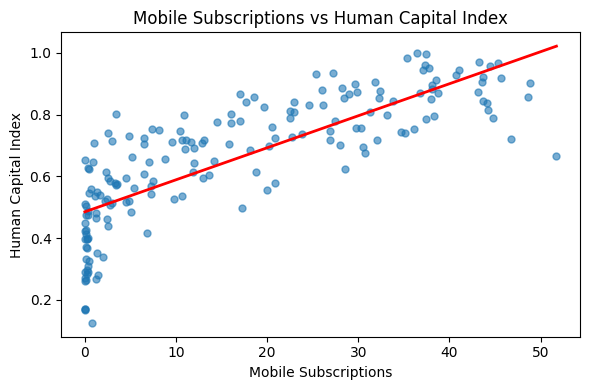

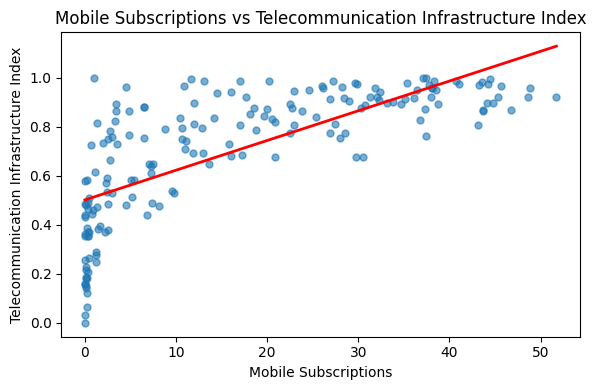

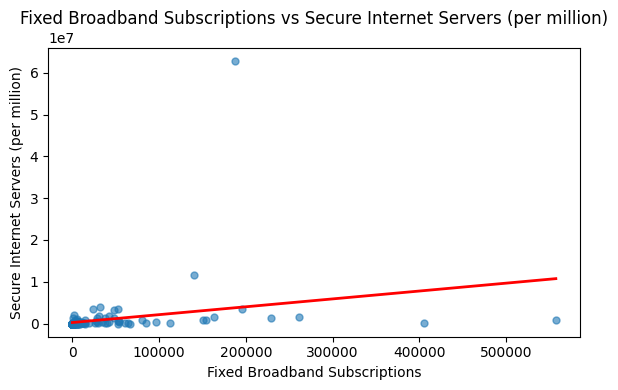

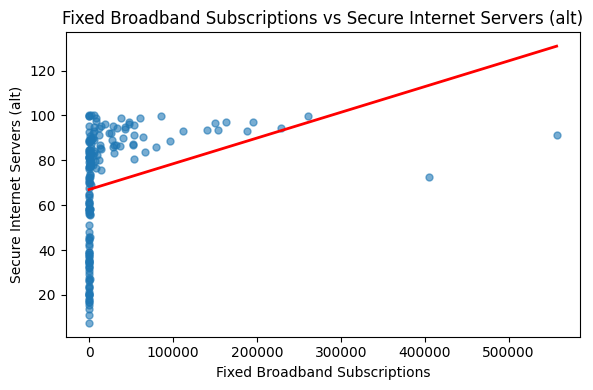

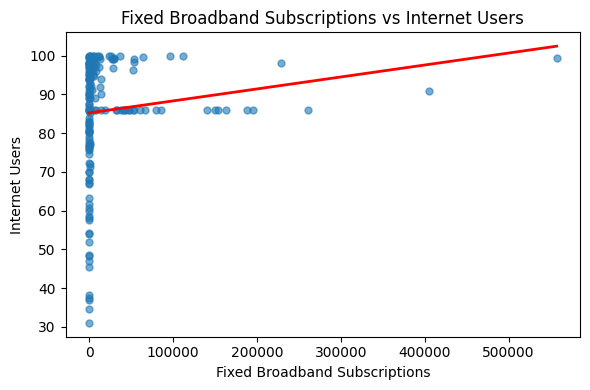

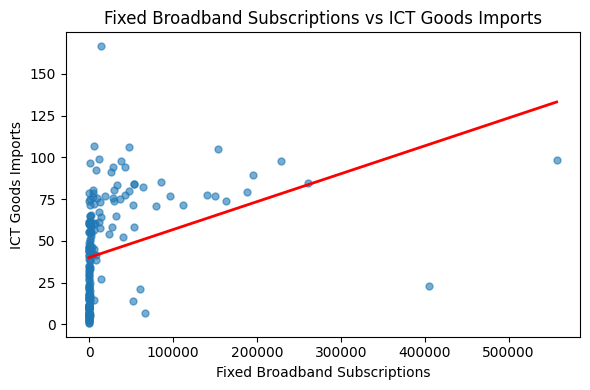

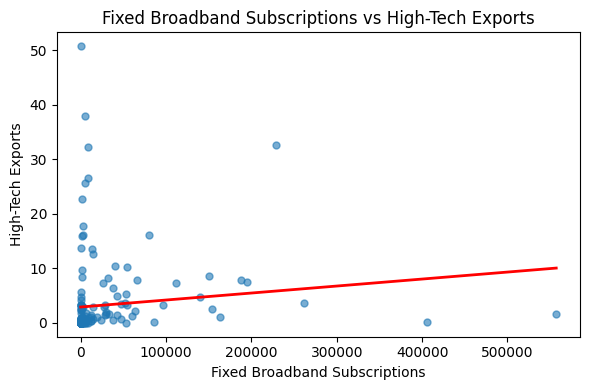

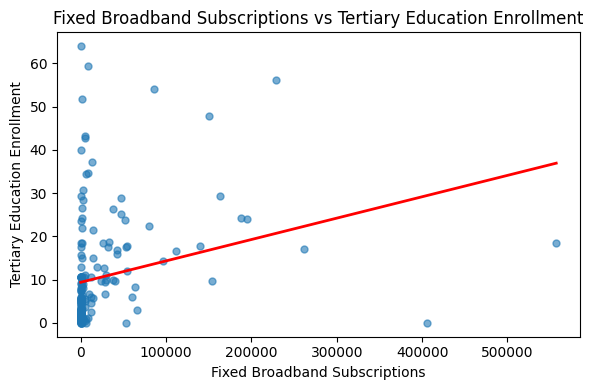

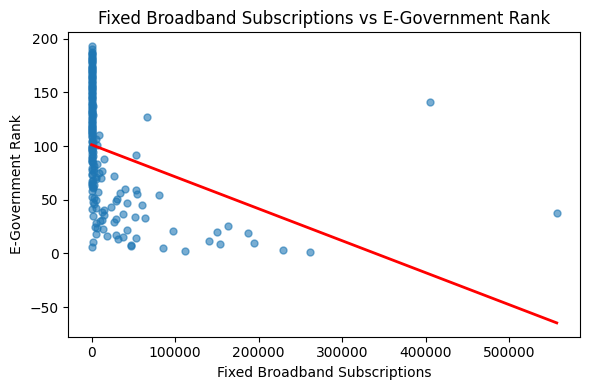

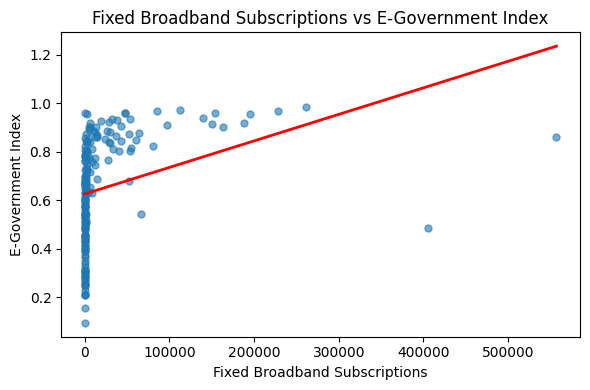

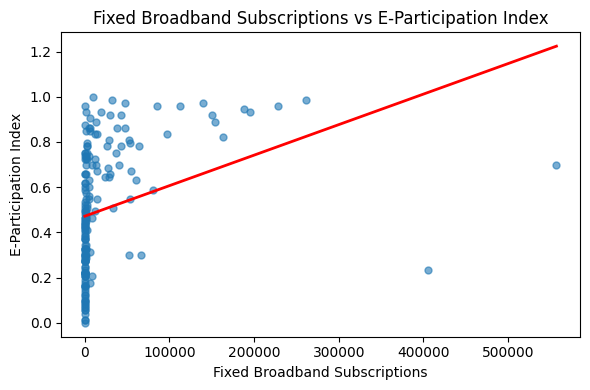

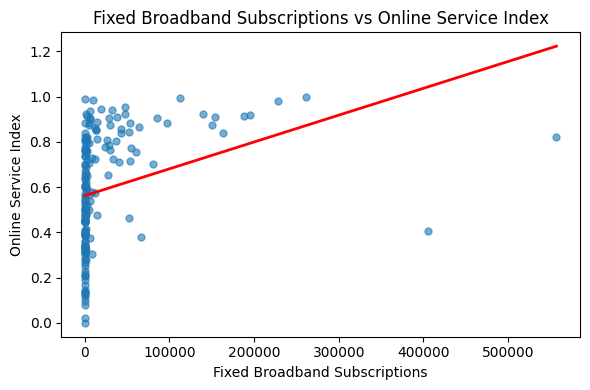

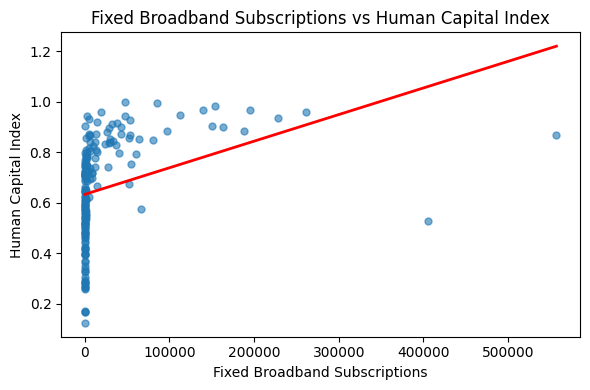

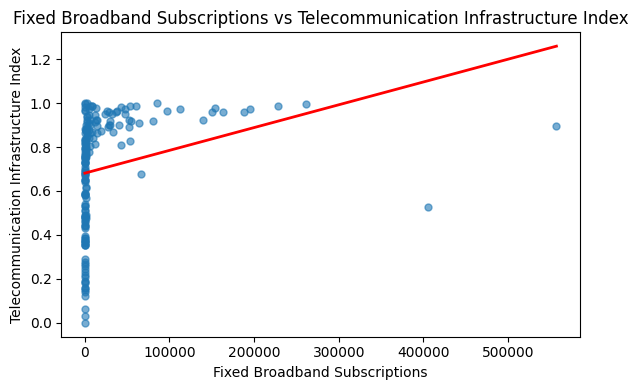

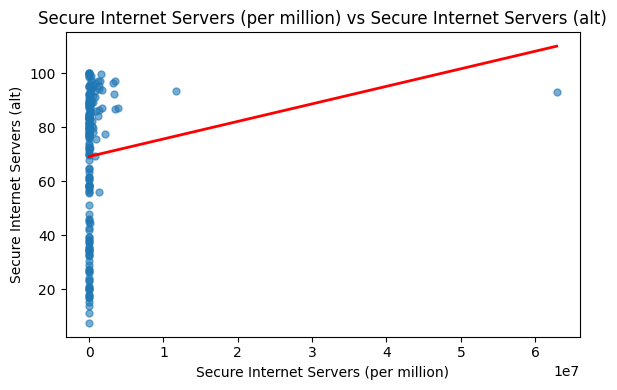

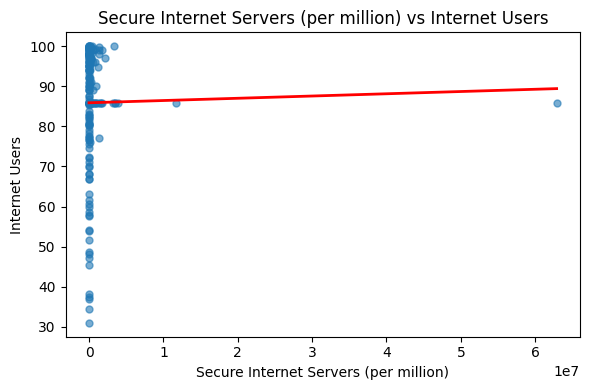

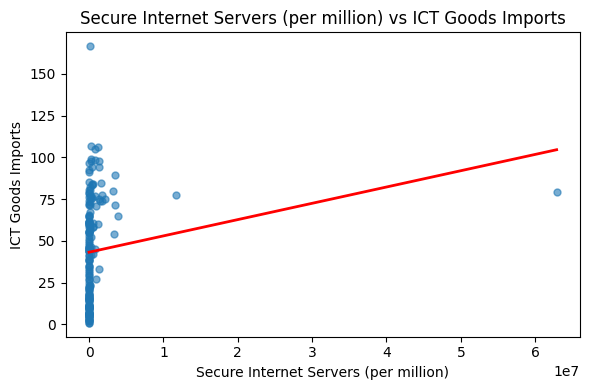

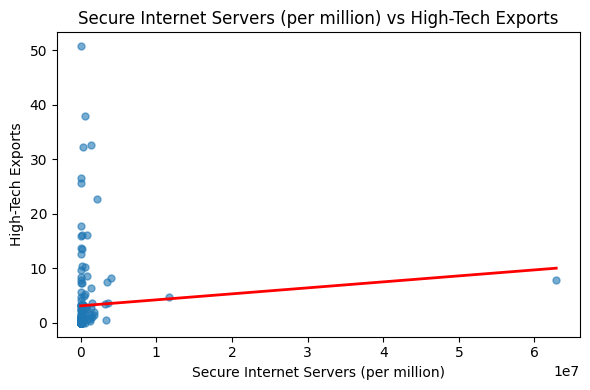

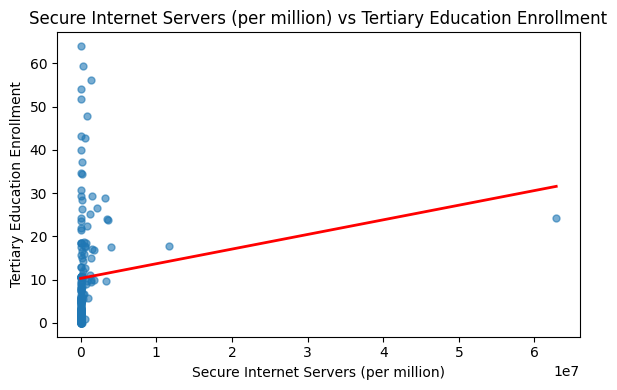

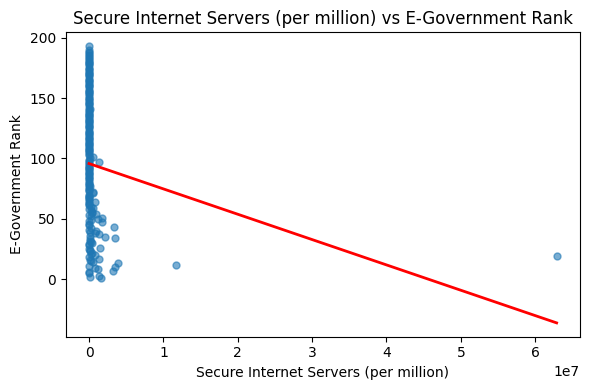

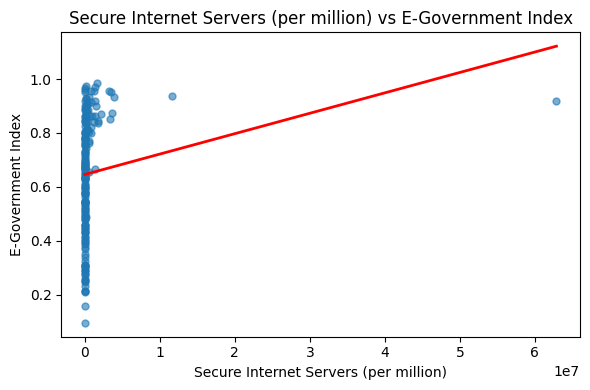

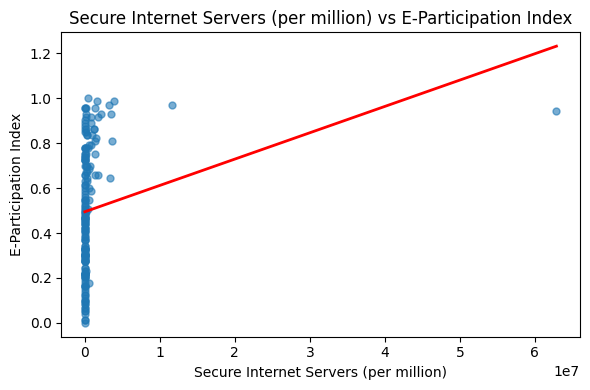

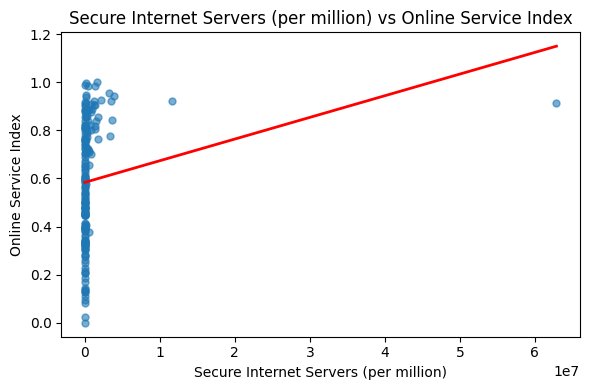

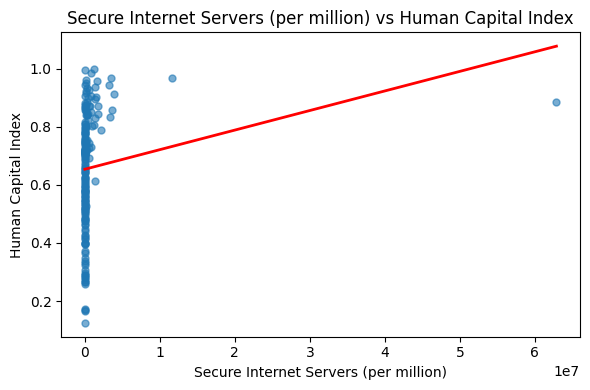

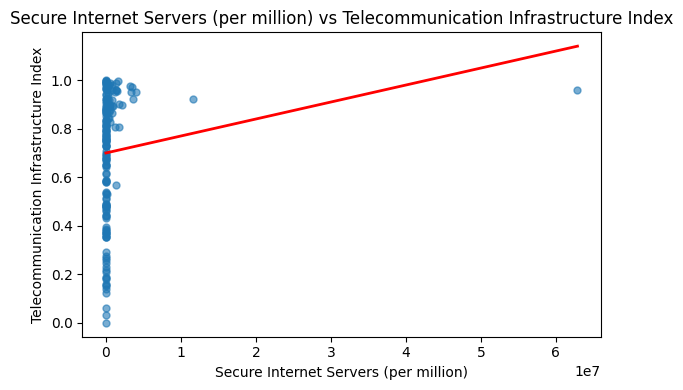

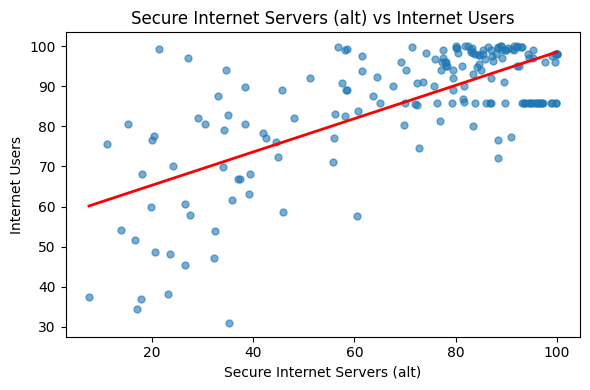

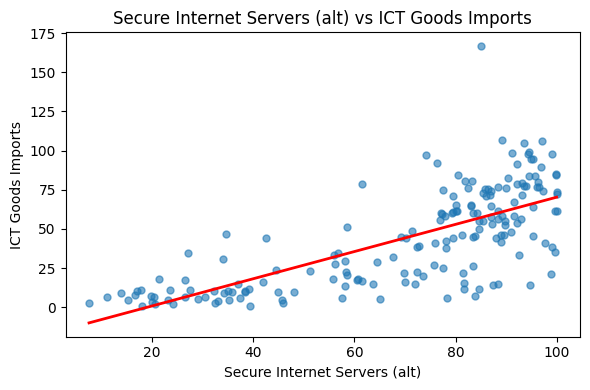

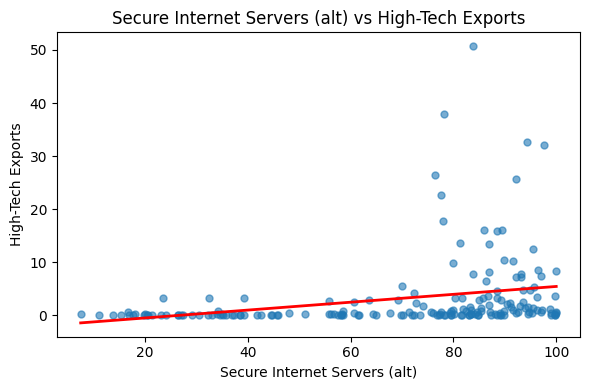

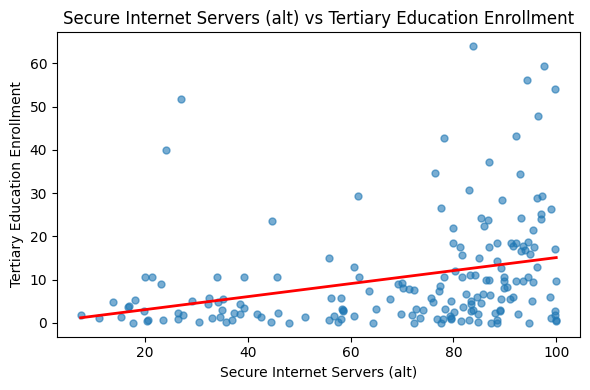

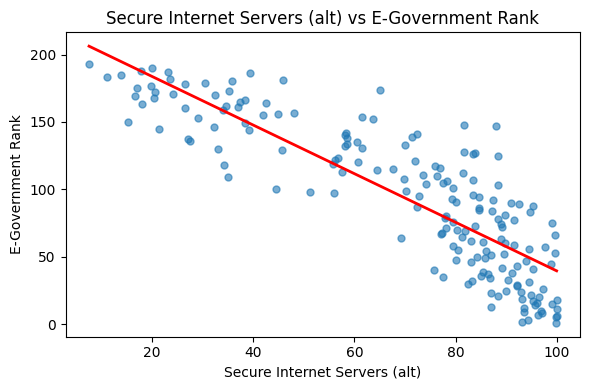

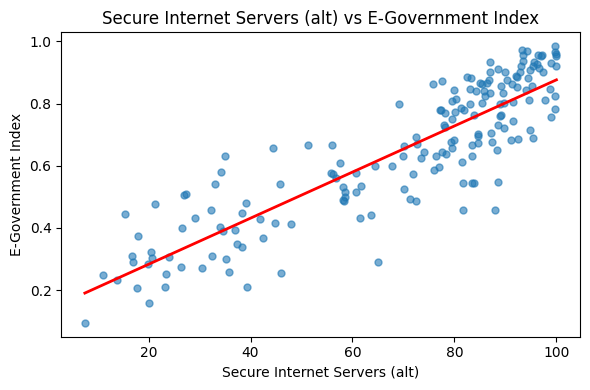

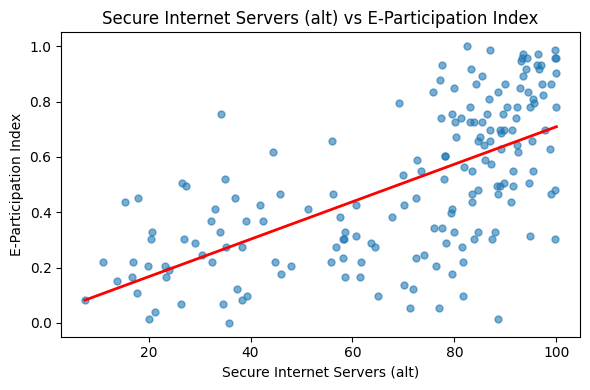

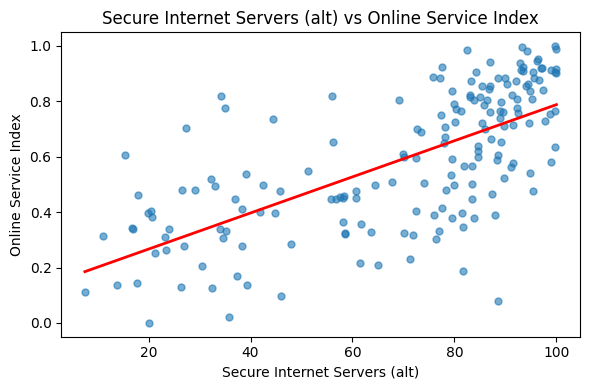

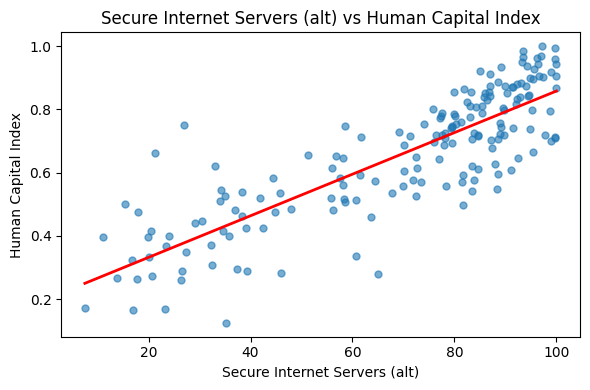

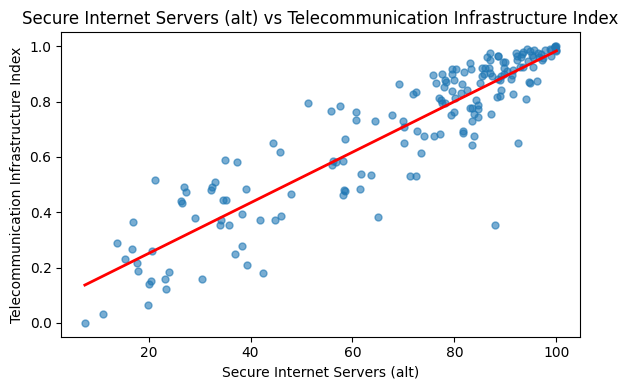

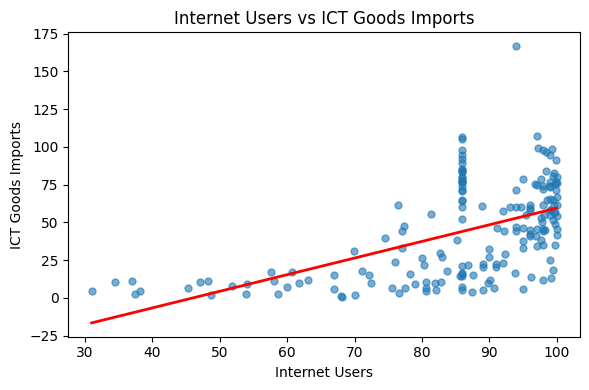

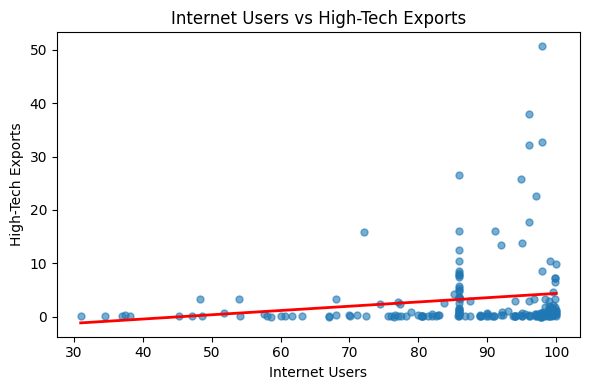

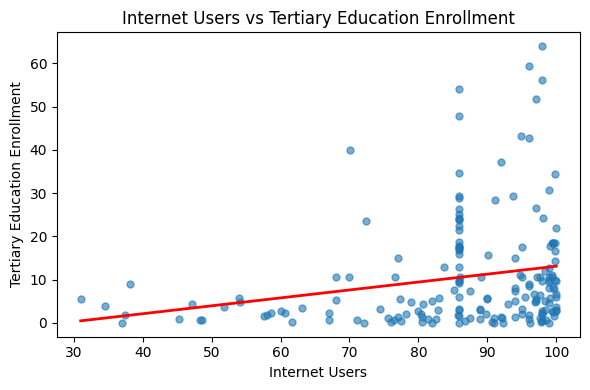

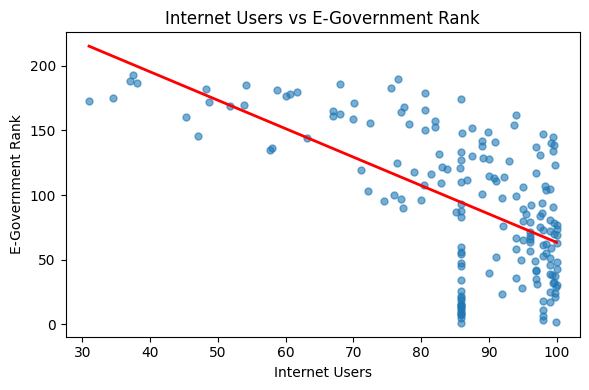

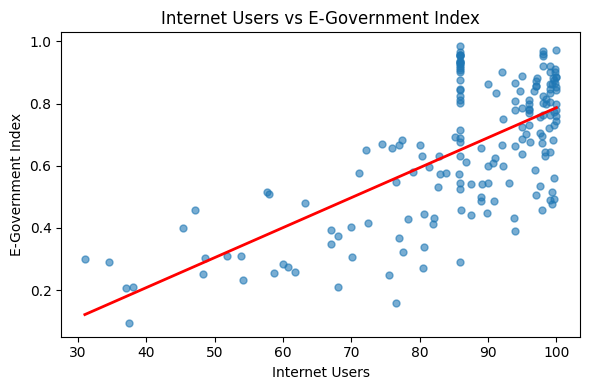

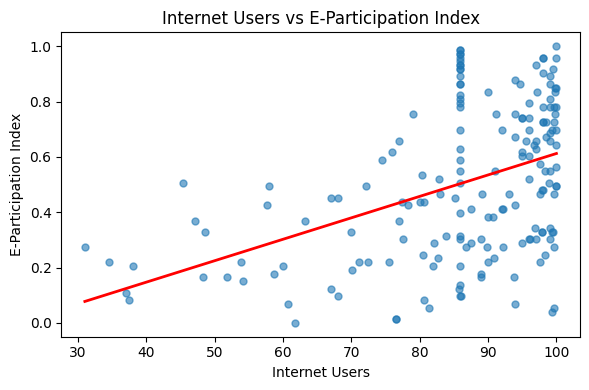

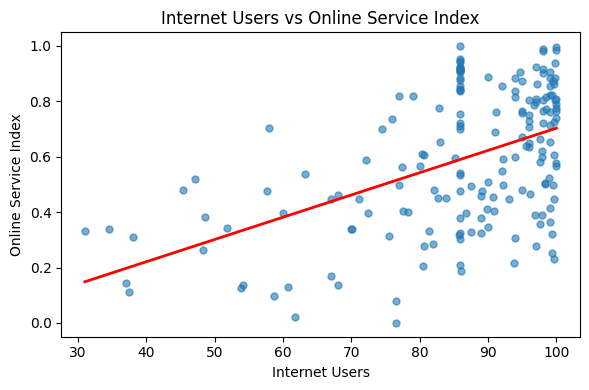

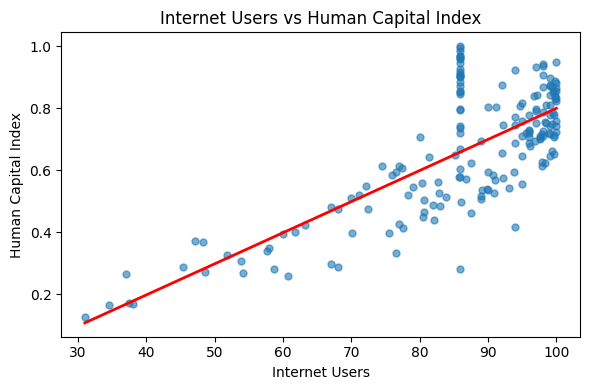

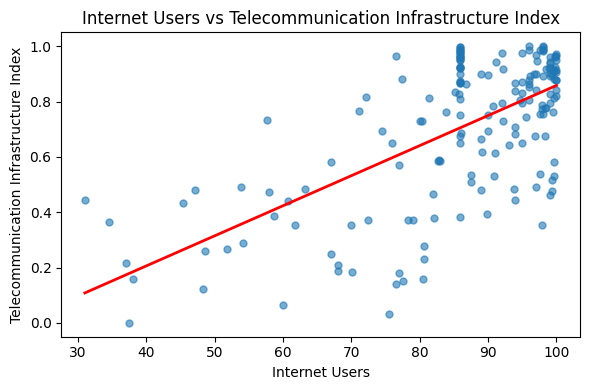

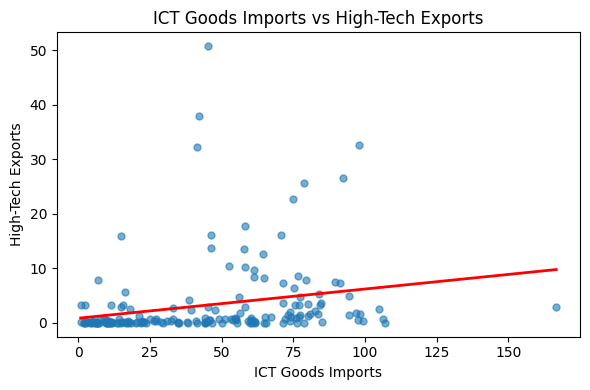

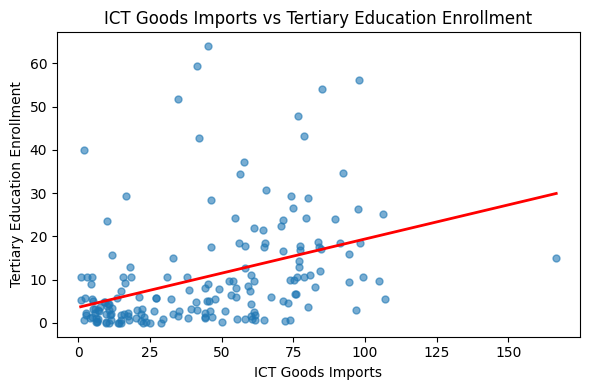

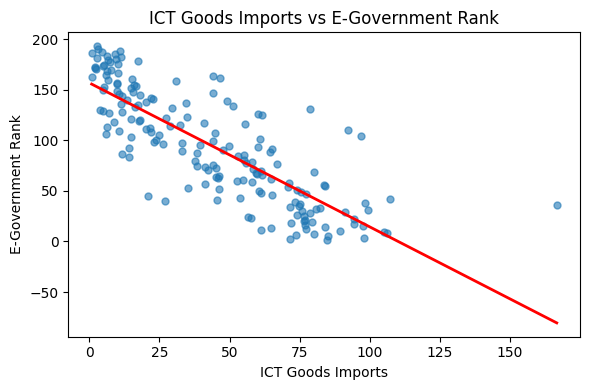

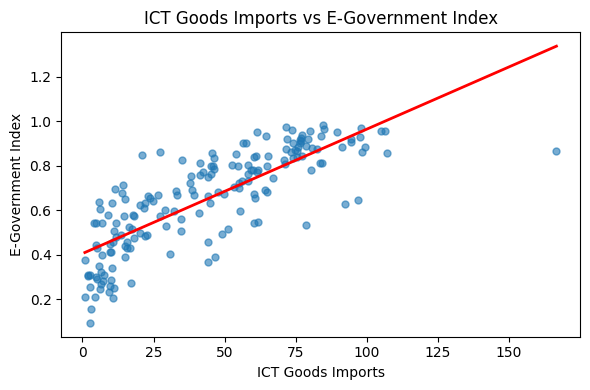

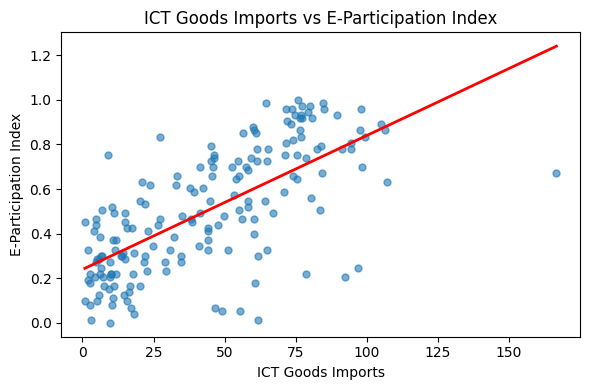

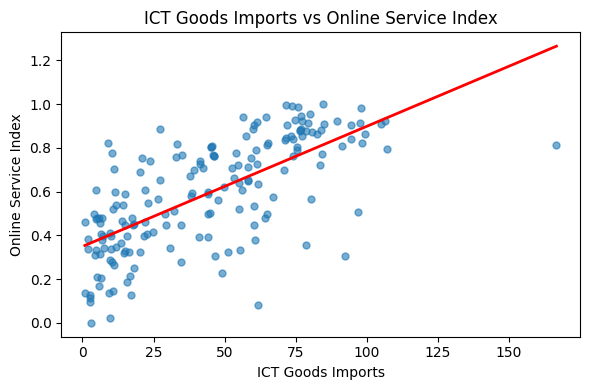

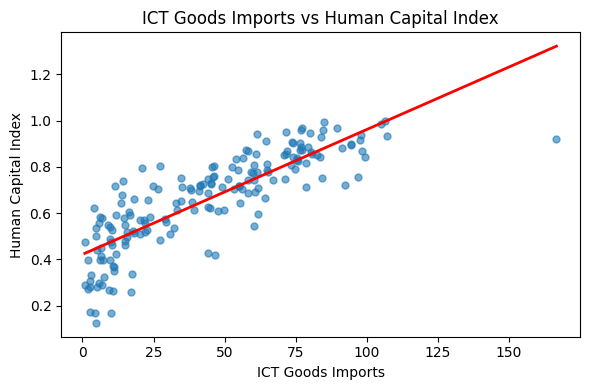

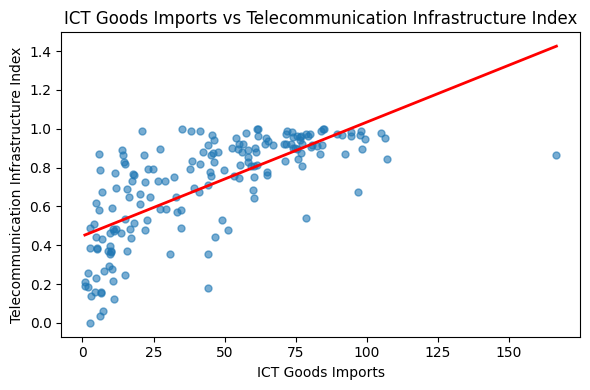

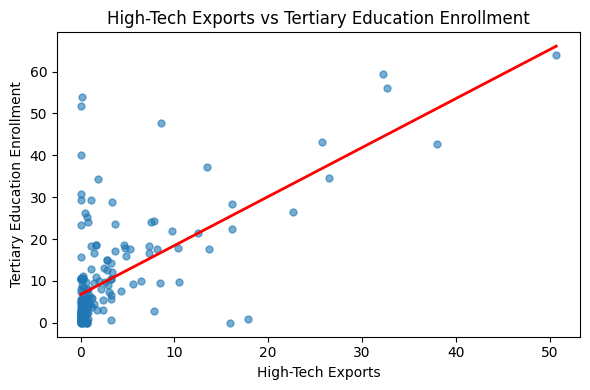

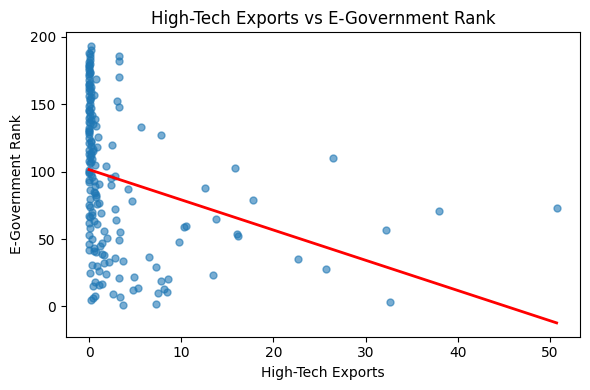

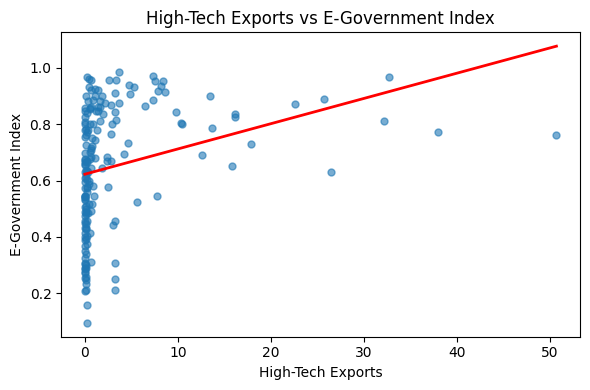

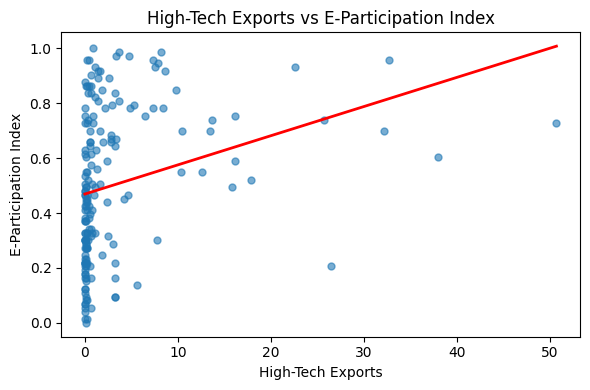

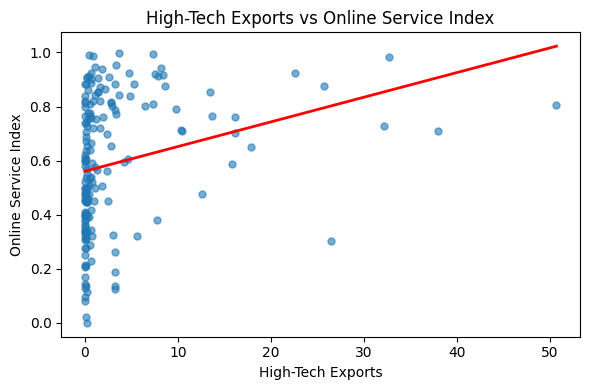

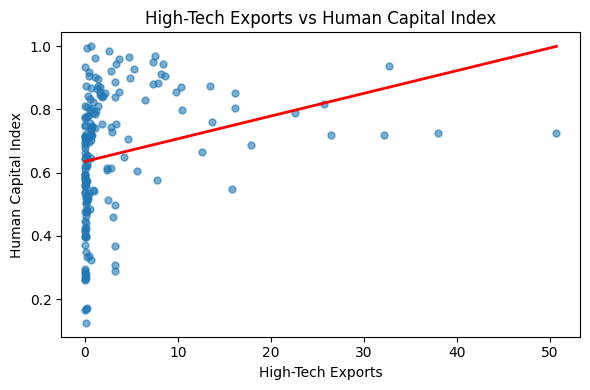

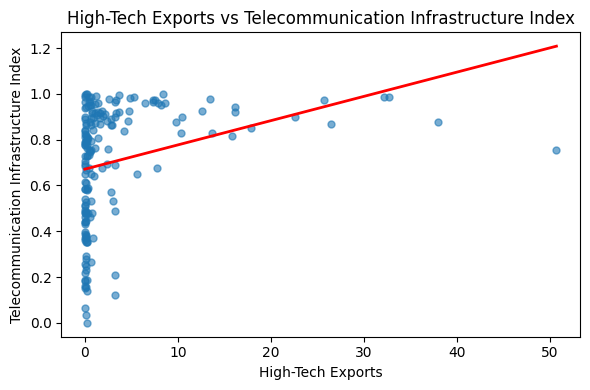

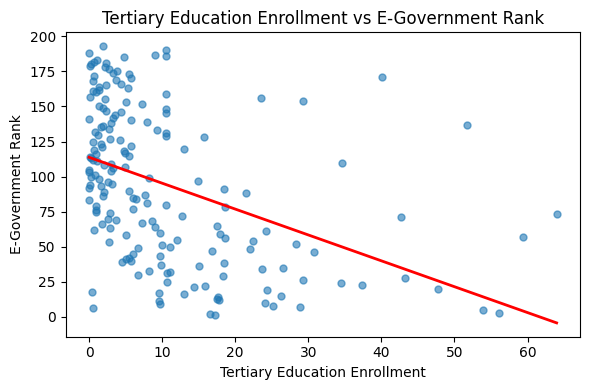

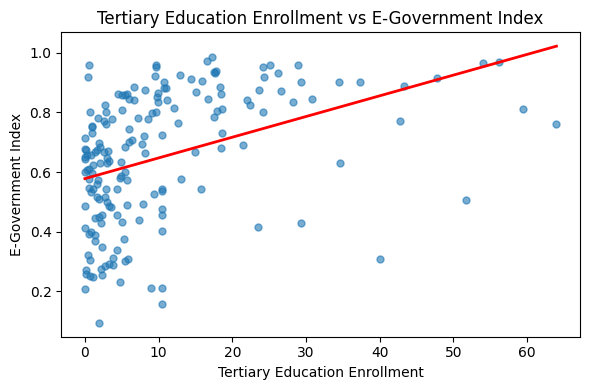

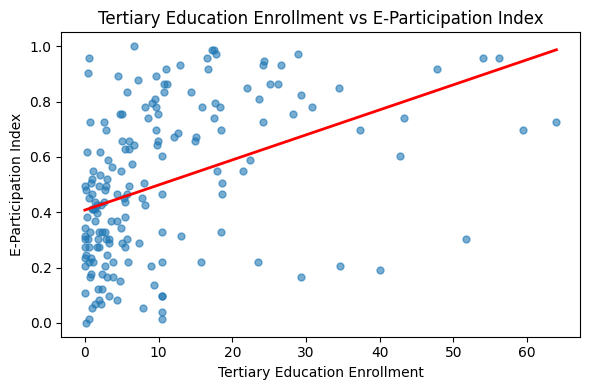

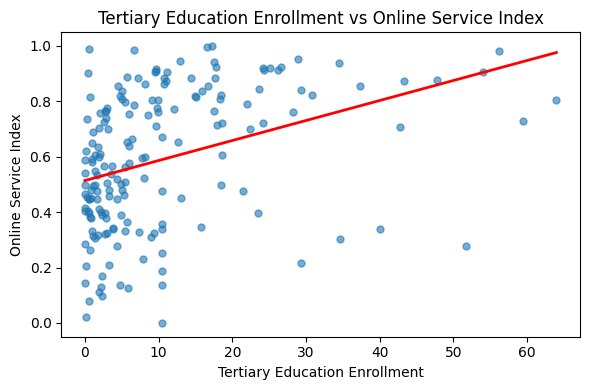

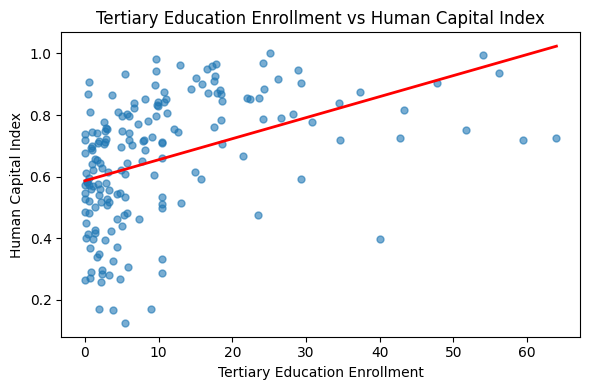

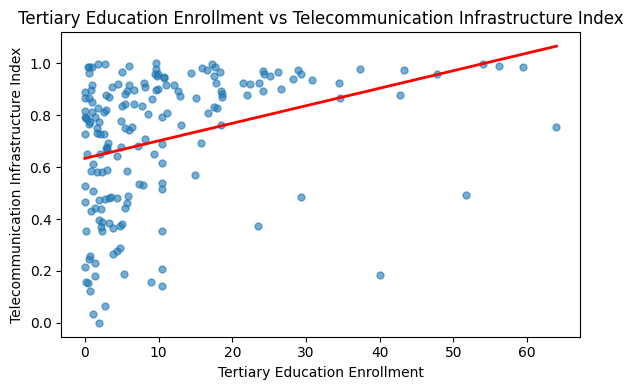

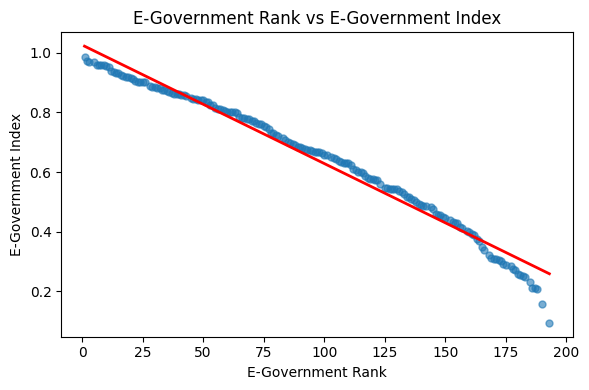

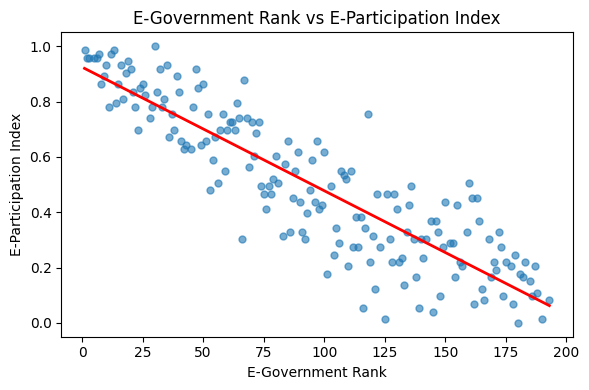

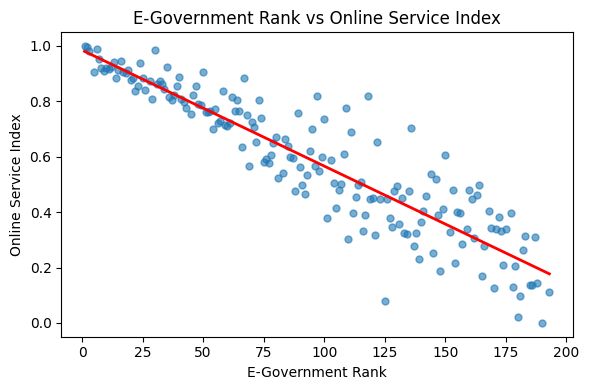

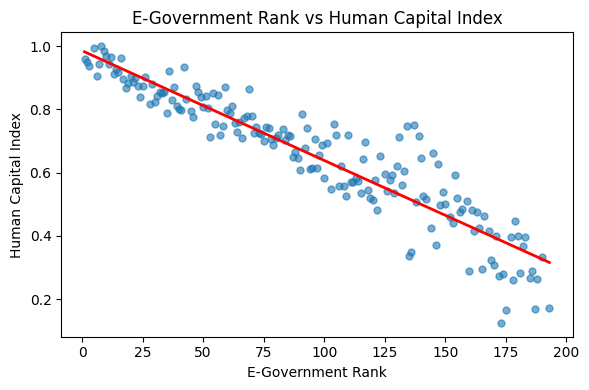

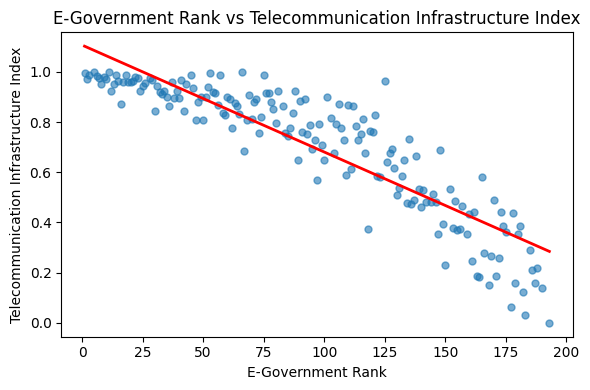

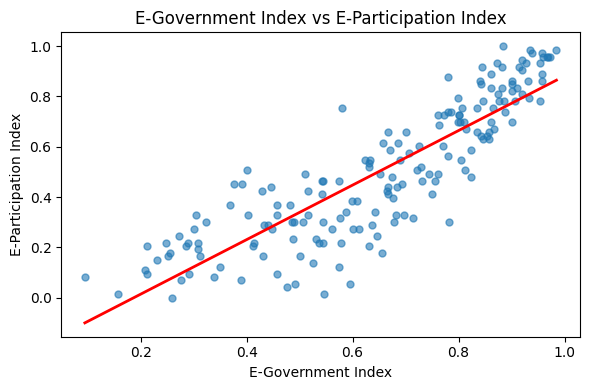

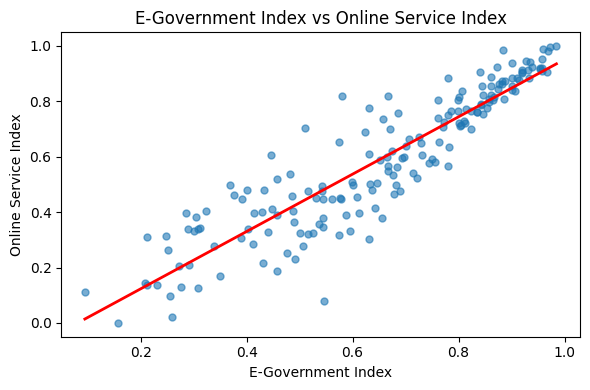

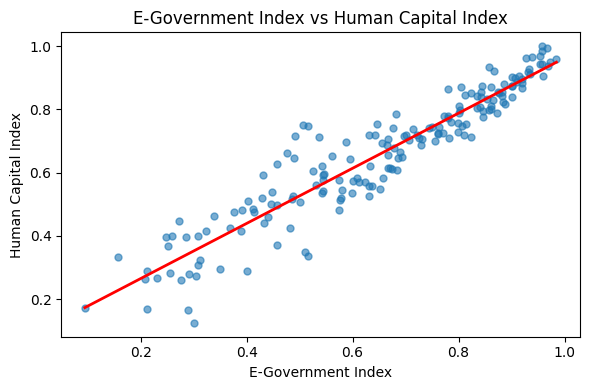

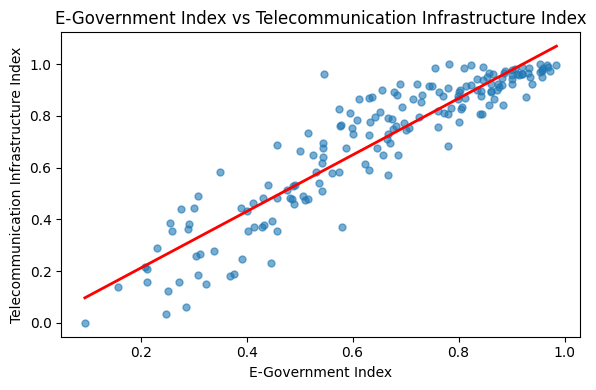

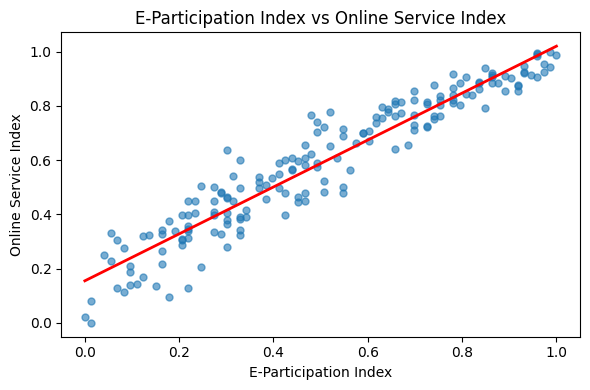

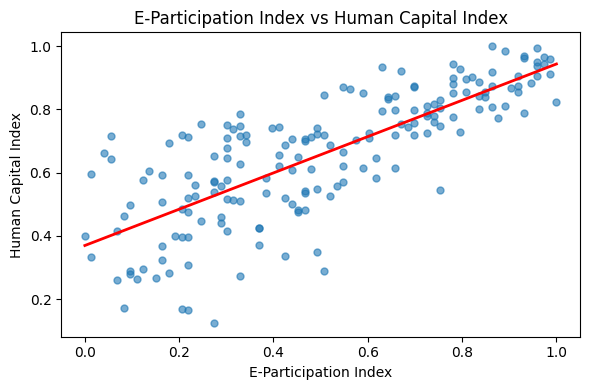

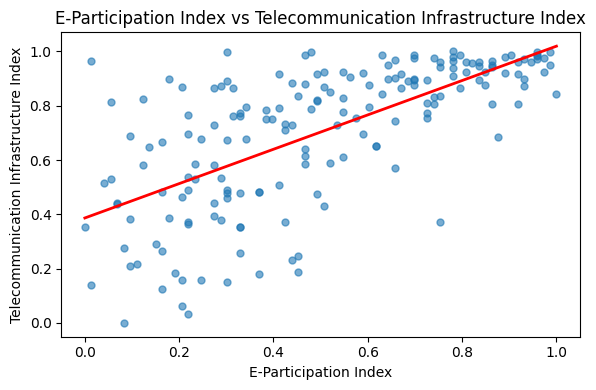

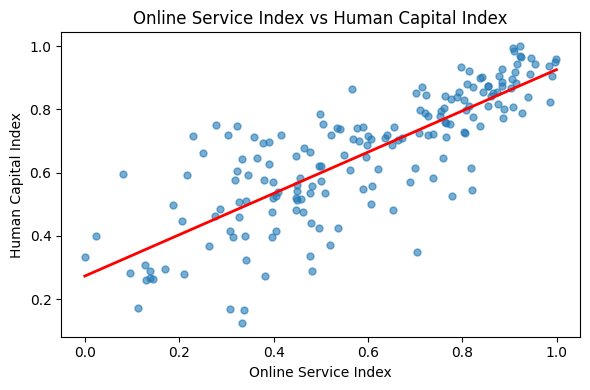

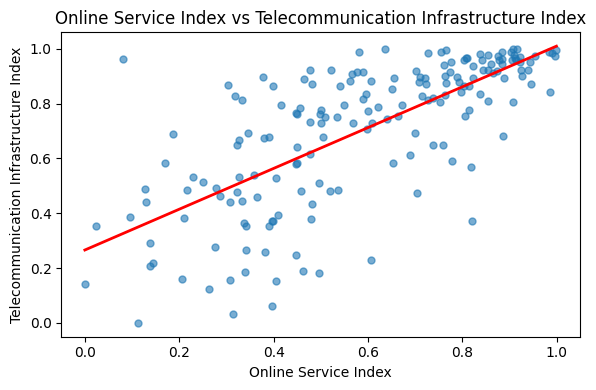

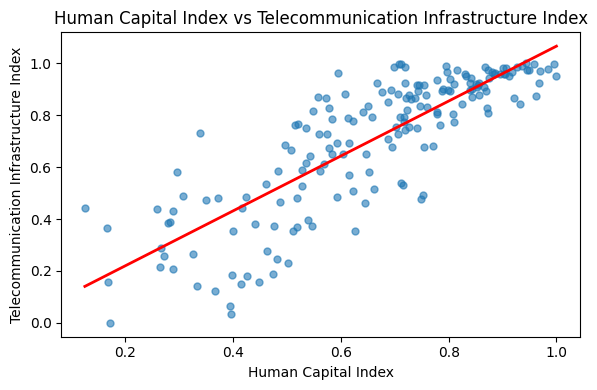

In [49]:
numeric_df = df.select_dtypes(include='number')

for x_var, y_var in combinations(numeric_df.columns, 2):
    x = numeric_df[x_var].dropna()
    y = numeric_df[y_var].dropna()

    common_index = x.index.intersection(y.index)
    x = x.loc[common_index]
    y = y.loc[common_index]

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.6, s=25)
    plt.title(f"{x_var} vs {y_var}")
    plt.xlabel(x_var)
    plt.ylabel(y_var)

    if len(x) > 1 and len(np.unique(x)) > 1:
        coeffs = np.polyfit(x, y, 1)
        poly_eq = np.poly1d(coeffs)
        plt.plot(np.sort(x), poly_eq(np.sort(x)), color='red', linewidth=2)

    plt.tight_layout()
    plt.show()


In [50]:
correlation_results = []

for x_var, y_var in combinations(numeric_df.columns, 2):
    x = numeric_df[x_var].dropna()
    y = numeric_df[y_var].dropna()
    
    # Align indices
    common_index = x.index.intersection(y.index)
    x = x.loc[common_index]
    y = y.loc[common_index]

    if len(x) > 1 and len(y) > 1 and len(np.unique(x)) > 1 and len(np.unique(y)) > 1:
        corr, p_val = pearsonr(x, y)
        correlation_results.append({
            "Variable 1": x_var,
            "Variable 2": y_var,
            "Pearson r": round(corr, 4),
            "p-value": f"{p_val:.4e}"
        })

correlation_df = pd.DataFrame(correlation_results)

print("\nPearson Correlation Table:\n")
print(correlation_df.to_string(index=False))


Pearson Correlation Table:

                           Variable 1                             Variable 2  Pearson r     p-value
                  Adult Literacy Rate                    ICT Service Exports     0.2166  3.6901e-03
                  Adult Literacy Rate                        R&D Expenditure     0.0831  2.7001e-01
                  Adult Literacy Rate                       Journal Articles     0.0361  6.3190e-01
                  Adult Literacy Rate                    Patent Applications     0.1029  1.7182e-01
                  Adult Literacy Rate                   Mobile Subscriptions     0.0833  2.6872e-01
                  Adult Literacy Rate          Fixed Broadband Subscriptions     0.1668  2.6020e-02
                  Adult Literacy Rate  Secure Internet Servers (per million)    -0.0094  9.0084e-01
                  Adult Literacy Rate          Secure Internet Servers (alt)     0.0165  8.2690e-01
                  Adult Literacy Rate                         Internet 

based on this table the variables that have to be removed are 
- E-Government rank
- Online Service Index
- Journal Articles
- Human Capital Index

This is because they have high correlations with these variables:
- E-Goverment Index - -0.9892
- Online Service Index - 0.9519
- R&D Expenditure - 0.9169
- E-Government Index - 0.9402

In [51]:
columns_to_drop = [
    "E-Government Rank",
    "Online Service Index",
    "Journal Articles",
    "Human Capital Index"
]

reduced_df = df.drop(columns=columns_to_drop)
reduced_df.to_csv('../cleaning_process/reduced_data.csv', index=False)
print(reduced_df.columns.to_list())

['Country', 'Adult Literacy Rate', 'ICT Service Exports', 'R&D Expenditure', 'Patent Applications', 'Mobile Subscriptions', 'Fixed Broadband Subscriptions', 'Secure Internet Servers (per million)', 'Secure Internet Servers (alt)', 'Internet Users', 'ICT Goods Imports', 'High-Tech Exports', 'Tertiary Education Enrollment', 'E-Government Index', 'E-Participation Index', 'Telecommunication Infrastructure Index']


Before starting Linear Regression, we need to group the variables into sub-indices 
- Education & Human Capital
    -  Adult Literacy Rate
    - Tertiary Education Enrollment
- Innovation & R&D
    - R&D Expenditure
    - Patent Applications
- Access & Connectivity
    - Mobile Subscriptions
    - Fixed Broadband Subscriptions
    - Internet Users    
- Infrastructure & Security
    - Secure Internet Servers (per million)
    - Secure Internet Servers (alt)
    - Telecommunication Infrastructure Index
- Digital Trade & Economy
    - ICT Goods Imports
    - High-Tech Exports
    - ICT Service Exports
- Digital Governance & Participation
    - E-Government Index
    - E-Participation Index

In [52]:
sub_indices = {
    "education_human_capital": [
        "Country", "Adult Literacy Rate", "Tertiary Education Enrollment"
    ],
    "innovation_rd": [
        "Country", "R&D Expenditure", "Patent Applications"
    ],
    "access_connectivity": [
        "Country", "Mobile Subscriptions", "Fixed Broadband Subscriptions", "Internet Users"
    ],
    "infrastructure_security": [
        "Country", "Secure Internet Servers (per million)", "Secure Internet Servers (alt)",
        "Telecommunication Infrastructure Index"
    ],
    "digital_trade_economy": [
        "Country", "ICT Goods Imports", "High-Tech Exports", "ICT Service Exports"
    ],
    "digital_governance_participation": [
        "Country", "E-Government Index", "E-Participation Index"
    ]
}

for name, columns in sub_indices.items():
    sub_df = df[columns]
    sub_df.to_csv(f"sub_indices/{name}.csv", index=False)
    print(f"Saved {name}.csv")

Saved education_human_capital.csv
Saved innovation_rd.csv
Saved access_connectivity.csv
Saved infrastructure_security.csv
Saved digital_trade_economy.csv
Saved digital_governance_participation.csv


<h1>Multi Linear Regression</h1>

In [53]:
ac_df = pd.read_csv("sub_indices/access_connectivity.csv")

In [54]:
def plot_ols_regression(x, y):
    y_const = sm.add_constant(y)
    model = sm.OLS(x, y_const)
    result = model.fit()

    print(result.summary())

x = ac_df["Internet Users"]
y = ac_df["Mobile Subscriptions"]
plot_ols_regression(x, y)

x = ac_df["Internet Users"]
y = ac_df["Fixed Broadband Subscriptions"]
plot_ols_regression(x, y)

x = ac_df["Mobile Subscriptions"]
y = ac_df["Fixed Broadband Subscriptions"]
plot_ols_regression(x, y)


                            OLS Regression Results                            
Dep. Variable:         Internet Users   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     52.12
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.51e-11
Time:                        18:40:09   Log-Likelihood:                -714.81
No. Observations:                 178   AIC:                             1434.
Df Residuals:                     176   BIC:                             1440.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   78.0187 

Based on the results Broadband Subscriptions appears to be redundant when compared to Mobile Subscriptions as Mobile Subscriptions explains Internet users more efficiently.

In [55]:
ac_df = ac_df.drop(columns=["Fixed Broadband Subscriptions"])
ac_df.to_csv("sub_indices/access_connectivity_cleaned.csv", index=False)

In [56]:
dgp_df = pd.read_csv("sub_indices/digital_governance_participation.csv")

x = dgp_df["E-Government Index"]
y = dgp_df["E-Participation In dex"]
plot_ols_regression(x, y)

x = dgp_df["E-Participation Index"]
y = dgp_df["E-Government Index"]
plot_ols_regression(x, y)


KeyError: 'E-Participation In dex'

Since both indicies have quite high correlation E-Paricipation Index will be kept and E-Government Index will be dropped

<strong>CONSIDERING E_PARTICIPATION INDEX IS ALREADY AN INDEX AND IS THE LAST VARIABLE IN THIS SUBSET NO MORE WORK NEEDS TO BE DONE HERE.</strong>

In [ ]:
dgp_df = dgp_df.drop(columns=["E-Government Index"])
dgp_df.to_csv("sub_indices/digital_governance_participation_cleaned.csv", index=False)

In [ ]:
dte_df = pd.read_csv("sub_indices/digital_trade_economy.csv")

x = dte_df["ICT Service Exports"]
y = dte_df["ICT Goods Imports"]
plot_ols_regression(x, y)

x = dte_df["ICT Service Exports"]
y = dte_df["High-Tech Exports"]
plot_ols_regression(x, y)

x = dte_df["ICT Goods Imports"]
y = dte_df["High-Tech Exports"]
plot_ols_regression(x, y)

                             OLS Regression Results                            
Dep. Variable:     ICT Service Exports   R-squared:                       0.218
Model:                             OLS   Adj. R-squared:                  0.214
Method:                  Least Squares   F-statistic:                     49.10
Date:                 Wed, 07 May 2025   Prob (F-statistic):           4.98e-11
Time:                         03:51:01   Log-Likelihood:                -207.69
No. Observations:                  178   AIC:                             419.4
Df Residuals:                      176   BIC:                             425.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2547

Based on the results, High-Tech Exports can be excluded in further analysis as both statistically and thematically it does not indicate a countries digital trade capacity.

In [ ]:
dte_df = dte_df.drop(columns=["High-Tech Exports"])
dte_df.to_csv("sub_indices/digital_trade_economy_cleaned.csv", index=False)

In [ ]:
ehc_df = pd.read_csv("sub_indices/education_human_capital.csv")

x = ehc_df["Adult Literacy Rate"]
y = ehc_df["Tertiary Education Enrollment"]
plot_ols_regression(x, y)

x = ehc_df["Tertiary Education Enrollment"]
y = ehc_df["Adult Literacy Rate"]
plot_ols_regression(x, y)

                             OLS Regression Results                            
Dep. Variable:     Adult Literacy Rate   R-squared:                       0.018
Model:                             OLS   Adj. R-squared:                  0.012
Method:                  Least Squares   F-statistic:                     3.240
Date:                 Wed, 07 May 2025   Prob (F-statistic):             0.0736
Time:                         04:00:24   Log-Likelihood:                -682.80
No. Observations:                  178   AIC:                             1370.
Df Residuals:                      176   BIC:                             1376.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
cons

Both indicators will be kept as both explain different areas of the education system for a country making them equally as important

In [ ]:
is_df = pd.read_csv("sub_indices/infrastructure_security.csv")

x = is_df["Telecommunication Infrastructure Index"]
y = is_df["Secure Internet Servers (per million)"]
plot_ols_regression(x, y)

x = is_df["Telecommunication Infrastructure Index"]
y = is_df["Secure Internet Servers (alt)"]
plot_ols_regression(x, y)

x = is_df["Secure Internet Servers (alt)"]
y = is_df["Secure Internet Servers (per million)"]
plot_ols_regression(x, y)

                                      OLS Regression Results                                      
Dep. Variable:     Telecommunication Infrastructure Index   R-squared:                       0.017
Model:                                                OLS   Adj. R-squared:                  0.011
Method:                                     Least Squares   F-statistic:                     3.018
Date:                                    Wed, 07 May 2025   Prob (F-statistic):             0.0841
Time:                                            04:09:21   Log-Likelihood:                -10.457
No. Observations:                                     178   AIC:                             24.91
Df Residuals:                                         176   BIC:                             31.28
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
          

Based on the results Secure Internet Servers (per million) is statically redundant therefore it is dropped

In [ ]:
is_df = is_df.drop(columns=["Secure Internet Servers (per million)"])
is_df.to_csv("sub_indices/infrastructure_security_cleaned.csv", index=False)

In [ ]:
ird_df = pd.read_csv("sub_indices/innovation_rd.csv")

x = ird_df["R&D Expenditure"]
y = ird_df["Patent Applications"]
plot_ols_regression(x, y)

x = ird_df["Patent Applications"]
y = ird_df["R&D Expenditure"]
plot_ols_regression(x, y)


                            OLS Regression Results                            
Dep. Variable:        R&D Expenditure   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5646
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.453
Time:                        04:15:14   Log-Likelihood:                -2258.1
No. Observations:                 178   AIC:                             4520.
Df Residuals:                     176   BIC:                             4527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3522.8929   1

Both are strong indicators that can be used for the sub index therefore both are kept

Before we need to standardise our data

<h1>Standardisation</h1>

In [ ]:
def standardize_sub_index(file_path):
    df = pd.read_csv(file_path)

    country_col = df[['Country']]
    
    data_to_scale = df.drop(columns=['Country'])
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_to_scale)

    scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
    standardised_df = pd.concat([country_col, scaled_df], axis=1)

    return standardised_df

standarised_df = standardize_sub_index("sub_indices/access_connectivity_cleaned.csv")
standarised_df.to_csv("sub_indices/access_connectivity_standardised.csv", index=False)

standarised_df = standardize_sub_index("sub_indices/digital_governance_participation_cleaned.csv")
standarised_df.to_csv("sub_indices/digital_governance_participation_standardised.csv", index=False)

standarised_df = standardize_sub_index("sub_indices/digital_trade_economy_cleaned.csv")
standarised_df.to_csv("sub_indices/digital_trade_economy_standardised.csv", index=False)

standarised_df = standardize_sub_index("sub_indices/education_human_capital.csv")
standarised_df.to_csv("sub_indices/education_human_capital_standardised.csv", index=False)

standarised_df = standardize_sub_index("sub_indices/infrastructure_security_cleaned.csv")
standarised_df.to_csv("sub_indices/infrastructure_security_standardised.csv", index=False)

standarised_df = standardize_sub_index("sub_indices/innovation_rd.csv")
standarised_df.to_csv("sub_indices/innovation_rd_standardised.csv", index=False)

In [ ]:
def print_numeric_column_means(file_path):
    df = pd.read_csv(file_path)
    
    numeric_cols = df.select_dtypes(include='number')
    
    for col in numeric_cols.columns:
        mean_val = numeric_cols[col].mean()
        print(f"{col}: {mean_val:.4f}")

print_numeric_column_means("sub_indices/access_connectivity_standardised.csv")
print_numeric_column_means("sub_indices/digital_governance_participation_standardised.csv")
print_numeric_column_means("sub_indices/digital_trade_economy_standardised.csv")
print_numeric_column_means("sub_indices/education_human_capital_standardised.csv")
print_numeric_column_means("sub_indices/infrastructure_security_standardised.csv")
print_numeric_column_means("sub_indices/innovation_rd_standardised.csv")


Mobile Subscriptions: 0.0000
Internet Users: 0.0000
E-Participation Index: -0.0000
ICT Goods Imports: 0.0000
ICT Service Exports: -0.0000
Adult Literacy Rate: 0.0000
Tertiary Education Enrollment: -0.0000
Secure Internet Servers (alt): 0.0000
Telecommunication Infrastructure Index: -0.0000
R&D Expenditure: 0.0000
Patent Applications: 0.0000


Now that the data is standardised, we can process with PCA
